# Fine-Tuning NuExtract 2.0-8B for Structured Information Extraction
This notebook contains the process of fine-tuning NuExtract, a model specifically tailored to structred IE of text documents and images. NuExtract is a product of NuMind, a company specialized in NLP - particularly information extraction and data annotation.

[**NuExtract-2.0-8B**](https://huggingface.co/numind/NuExtract-2.0-8B) is a product of fine-tuning Qwen2.5-VL-7B-Instruct using high quality training data (by the the NuMind team itself). However, even with good performance on structured IE tasks, *NuExtract-2.0 still struggles with (1) understanding long documents, (2) complex events and relations, and (3) generating nested JSON output*.

This is a problem that needs to be addressed for my research purpose that revolves round elite biographies and networks. Political elites tend to have lengthy careers with complicated experiences and relations over a long period of time. To construct a dataset on social networks of elites, I need to extract their (often long) biographical information in a way that require an LLM to <u>go beyond simple named entity recognition (NER)</u> and
* Recognize complex, nested pieces of information & extract them into nested outputs (<u>see JSON schema below</u>)
  * E.g., Long biographical documents that include multiple entires of educational and job experiences, each of which contains relevant (nested) pieces of information like `organization name`, `timeframe`, `location`, etc.
* Detect complicated relationships and events, which often include tangled interactions between multiple entities
  * E.g., elites who used to be allies but then became rivals during an event.
  * E.g., elites who rose in power but were then removed from power in the same event.
* Comprehend the interconnectivity of experiences and events over a long document.
  * E.g., Jobs and educational experiences that are far away, yet helped shaping an elite's relations and beliefs.
  * E.g., elites who used to be allies but then became rivals over a long period of time.





### Setting Up

In [ ]:
# %%capture
# !pip uninstall -y pyarrow
# !pip install --no-cache-dir --force-reinstall "pyarrow>=16.0.0"
# !pip install --no-cache-dir --force-reinstall datasets

In [ ]:
%%capture
!pip install -U trl "transformers>=4.45"  accelerate  peft pandas openpyxl bitsandbytes  datasets

In [ ]:
# %%capture
# !pip install -U flash-attn --no-build-isolation

In [ ]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
import os
import json
from dataclasses import dataclass
from typing import Any, Dict, List, Optional

import pandas as pd
import torch
import random
from datasets import Dataset, concatenate_datasets

from transformers import AutoProcessor, AutoModelForVision2Seq

from trl import SFTTrainer, SFTConfig
from peft import LoraConfig, get_peft_model, TaskType

In [ ]:
print(torch.cuda.is_available())
print(torch.version)
print(torch.cuda.get_device_name(0))

True
<module 'torch.version' from '/usr/local/lib/python3.12/dist-packages/torch/version.py'>
NVIDIA A100-SXM4-80GB


In [ ]:
!nvidia-smi

Wed Dec 24 02:11:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   35C    P0             53W /  400W |       5MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

### Initialize NuExtract Model & Prepping the Data

In [ ]:
# =========================
# 1) Full template schema
# =========================
FULL_TEMPLATE = {
  "Name": "",
  "Name_Other": [],
  "BirthYear": "",
  "DeathYear": "",
  "Birthplace": {"City": "", "City_OtherName": [], "Region": "", "Region_OtherName": []},
  "Ethnicity": [],
  "Education": [{"School": "", "OtherName": [], "Start": "", "End": "", "Level": "", "Field": "", "Location": []}],
  "MilitaryTitle": [{"Title": "", "YearReceived": ""}],
  "Job": [{"Start": "", "End": "", "Position": "", "Location": [], "Org_Main_Name": "", "Org_Main_OtherName": "", "Org_Department": "", "Org_Unit": ""}],
  "Retired": [{"Date": "", "Detail": []}],
  "Dismissed": [{"Date": "", "Detail": []}],
  "Resigned": [{"Date": "", "Detail": []}],
  "Arrested": [{"Date": "", "Detail": []}],
  "Exiled": [{"Date": "", "Detail": []}],
  "Killed": [{"Date": "", "Detail": []}],
  "FamilyMember": [{"Name": "", "Relation": ""}],
  "Colleague": [{"FirstMention_Year": "", "Name": []}],
  "Rival": [{"FirstMention_Year": "", "Name": []}]
}
TEMPLATE_JSON_STR = json.dumps(FULL_TEMPLATE, ensure_ascii=False, separators=(",", ":"))

In [ ]:
# =========================
# 2) Cleaning helpers
# =========================
def is_effectively_empty(v) -> bool:
    if v is None:
        return True
    if isinstance(v, str):
        return v.strip() == ""
    if isinstance(v, list):
        return True if len(v) == 0 else all(is_effectively_empty(x) for x in v)
    if isinstance(v, dict):
        return True if len(v) == 0 else all(is_effectively_empty(x) for x in v.values())
    return False


def clean_top_level_nulls(d: Dict[str, Any]) -> Dict[str, Any]:
    # Omit root key iff its entire subtree is empty
    return {k: v for k, v in d.items() if not is_effectively_empty(v)}


def normalize_label_json(label_text: str) -> str:
    label_text = (label_text or "").strip()
    obj = json.loads(label_text)  # require valid JSON labels
    obj = clean_top_level_nulls(obj)
    return json.dumps(obj, ensure_ascii=False, separators=(",", ":"))

In [ ]:
# =========================
# 3) Prompt construction
# =========================
def build_user_block(context: str, examples=None) -> str:
    icl = ""
    if examples:
        icl = "# Examples:\n"
        for ex in examples:
            icl += f"## Input:\n{ex['input']}\n## Output:\n{ex['output']}\n"

    return f"# Template:\n{TEMPLATE_JSON_STR}\n{icl}# Context:\n{context}"


def make_messages(user_text: str, assistant_text: Optional[str] = None) -> List[Dict[str, Any]]:
    msgs = [{"role": "user", "content": [{"type": "text", "text": user_text}]}]
    if assistant_text is not None:
        msgs.append({"role": "assistant", "content": [{"type": "text", "text": assistant_text}]})
    return msgs


In [ ]:
# =========================
# 4) Collator (text-only, mask prompt tokens)
# =========================
@dataclass
class NuExtractTextOnlyCollator:
    processor: Any
    pad_to_multiple_of: Optional[int] = 8

    def __call__(self, batch: List[Dict[str, Any]]) -> Dict[str, torch.Tensor]:
        user_texts = [
            self.processor.apply_chat_template(
                ex["messages"][:1], tokenize=False, add_generation_prompt=True
            )
            for ex in batch
        ]
        full_texts = [
            self.processor.apply_chat_template(
                ex["messages"], tokenize=False, add_generation_prompt=False
            )
            for ex in batch
        ]

        user_tok = self.processor(
            text=user_texts,
            return_tensors="pt",
            padding=True,
            pad_to_multiple_of=self.pad_to_multiple_of,
        )
        full_tok = self.processor(
            text=full_texts,
            return_tensors="pt",
            padding=True,
            pad_to_multiple_of=self.pad_to_multiple_of,
        )

        labels = full_tok["input_ids"].clone()
        pad_id = self.processor.tokenizer.pad_token_id
        labels[labels == pad_id] = -100

        for i in range(len(batch)):
            user_len = int(user_tok["attention_mask"][i].sum().item())
            labels[i, : max(user_len - 1, 0)] = -100

        full_tok["labels"] = labels
        return full_tok


### Load dataset & Split

In [ ]:
# =========================
# 5) Load data from XLSX
# =========================
XLSX_PATH = "/content/drive/llm_train_2025.12.10_finetune3_flat.xlsx"
INPUT_COL = "input"
LABEL_COL = "output"     # your sparse labels
OUTPUT_DIR = "/content/drive/NuExtract_v2"

SEED = 123
df = pd.read_excel(XLSX_PATH)
#df = df.dropna(subset=[INPUT_COL, LABEL_COL]).reset_index(drop=True)

records = []
bad_json = 0
for _, row in df.iterrows():
    context = str(row[INPUT_COL])
    label_text = str(row[LABEL_COL])

    try:
        label_norm = normalize_label_json(label_text)
    except Exception:
        bad_json += 1
        continue

    user_text = build_user_block(context)
    records.append({"messages": make_messages(user_text, label_norm)})

if len(records) == 0:
    raise RuntimeError("No usable rows. Check that output_flat contains valid JSON.")
if bad_json > 0:
    print(f"WARNING: skipped {bad_json} rows due to invalid JSON labels.")


### Splitting into Training Set, Validation Set, and Test Set
# Create test set FIRST (never used in training)
ds = Dataset.from_list(records).shuffle(seed=SEED)
split1 = ds.train_test_split(test_size=0.133, seed=SEED)
trainval_ds = split1["train"]
test_ds = split1["test"]   # 🔒 hold out completely

In [ ]:
# (Optional) validation split
split2 = trainval_ds.train_test_split(test_size=0.05, seed=SEED)
train_ds = split2["train"]
eval_ds  = split2["test"]

In [ ]:
print(
    f"Dataset split → "
    f"TrainEval: {len(trainval_ds)}, "
    f"Train: {len(train_ds)}, "
    f"Val: {len(eval_ds)}, "
    f"Test: {len(test_ds)}"
)

Dataset split → TrainEval: 265, Train: 251, Val: 14, Test: 41


In [ ]:
train_ds[0]

{'messages': [{'content': [{'text': '# Template:\n{"Name":"","Name_Other":[],"BirthYear":"","DeathYear":"","Birthplace":{"City":"","City_OtherName":[],"Region":"","Region_OtherName":[]},"Ethnicity":[],"Education":[{"School":"","OtherName":[],"Start":"","End":"","Level":"","Field":"","Location":[]}],"MilitaryTitle":[{"Title":"","YearReceived":""}],"Job":[{"Start":"","End":"","Position":"","Location":[],"Org_Main_Name":"","Org_Main_OtherName":"","Org_Department":"","Org_Unit":""}],"Retired":[{"Date":"","Detail":[]}],"Dismissed":[{"Date":"","Detail":[]}],"Resigned":[{"Date":"","Detail":[]}],"Arrested":[{"Date":"","Detail":[]}],"Exiled":[{"Date":"","Detail":[]}],"Killed":[{"Date":"","Detail":[]}],"FamilyMember":[{"Name":"","Relation":""}],"Colleague":[{"FirstMention_Year":"","Name":[]}],"Rival":[{"FirstMention_Year":"","Name":[]}]}\n# Context:\nNguyen Khoa Diem, also known as Nguyen Hai Duong, is a Vietnamese political elite born in 1943 in Hue city, Thua Thien Hue province. \n\nNguyen Kho

In [ ]:
test_ds.to_json(f"{OUTPUT_DIR}/llm_ft_2025.12.22_testset.jsonl", orient="records", lines=True)

Creating json from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

289822

### Loading Model, Processor, and LoRA

In [ ]:
# =========================
# 6) Load processor & model
# =========================
import importlib.util

MODEL_NAME = "numind/NuExtract-2.0-8B"

BF16 = True
FP16 = False

processor = AutoProcessor.from_pretrained(MODEL_NAME, trust_remote_code=True)

# FlashAttention2 if available; otherwise you can remove attn_implementation argument
attn_impl = "flash_attention_2" if importlib.util.find_spec("flash_attn") else "sdpa"
print("Using attention implementation:", attn_impl)

dtype = torch.bfloat16 if BF16 else (torch.float16 if FP16 else torch.float32)

model = AutoModelForVision2Seq.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True,
    torch_dtype=dtype,
    attn_implementation=attn_impl,
    device_map="auto",
)

model.config.use_cache = False  # required for training/GC

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/613 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

Using attention implementation: sdpa


/usr/local/lib/python3.12/dist-packages/transformers/models/auto/modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.69G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

In [ ]:
### Align tokenizer & model padding (IMPORTANT)
# Make sure padding is defined consistently
if processor.tokenizer.pad_token_id is None:
    processor.tokenizer.pad_token = processor.tokenizer.eos_token

if processor.tokenizer.bos_token_id is None:
    processor.tokenizer.bos_token = processor.tokenizer.eos_token # If BOS is None, set it (often to EOS for decoder-only-ish setups)

model.config.pad_token_id = processor.tokenizer.pad_token_id
model.generation_config.pad_token_id = processor.tokenizer.pad_token_id
model.config.bos_token_id = processor.tokenizer.bos_token_id
model.generation_config.bos_token_id = processor.tokenizer.bos_token_id

In [ ]:
# =========================
# 7) Add LoRA (PEFT) on top
# =========================
# These target module names are common across Qwen/Llama-style Transformer blocks.
# If you hit a "module not found" error, see notes below to auto-discover names.
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.01,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ],
)

model = get_peft_model(model, lora_config)

# Print trainable params
model.print_trainable_parameters()

trainable params: 47,589,376 || all params: 8,339,756,032 || trainable%: 0.5706


### Fine-tuning NuExtract

Experimentations showed that the best performance come from 2 rounds of fine-tuning.
* 1st Round: 4 epochs
  * Aggressive learning (Learning rate = 1e-4)
  * Purpose: For the LLM to learn the overall desired behavior (i.e. how to extract info & put it in the desired JSON structure)
* 2nd Round: 1 epoch
  * Less agressive learning (LR = 5e-5)
  * Purpose: push the model to learn better accuracy, especially for nested Job & Education entries.



In [ ]:
## Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = NVIDIA A100-SXM4-80GB. Max memory = 79.318 GB.
15.648 GB of memory reserved.


In [ ]:
### Trainer call back function (to be added to the Trainer Config Below)

from transformers import TrainerCallback

class StepAndEpochLossPrinter(TrainerCallback):
    def __init__(self, print_every=1):
        self.print_every = print_every
        self._printed_train_header = False
        self._printed_eval_header = False

    def on_log(self, args, state, control, logs=None, **kwargs):
        # Called whenever Trainer logs (controlled by logging_steps)
        if not logs:
            return

        # Training loss is usually in logs["loss"]
        if "loss" in logs and state.global_step % self.print_every == 0:
            if not self._printed_train_header:
                print("\nStep\tTraining Loss")
                self._printed_train_header = True
            print(f"{state.global_step}\t{logs['loss']:.6f}")

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        # Called after evaluation; metrics usually include "eval_loss"
        if not metrics:
            return
        if "eval_loss" in metrics:
            if not self._printed_eval_header:
                print("\nEpoch\tValidation Loss")
                self._printed_eval_header = True
            # state.epoch may be float; format nicely
            ep = state.epoch
            ep_str = f"{ep:.0f}" if ep is not None else "?"
            print(f"{ep_str}\t{metrics['eval_loss']:.6f}")


In [ ]:
# =========================
# 8) Training config (NuMind-style inline SFTConfig)
# =========================

# Mirror your Unsloth-like training params
MAX_SEQ_LEN = 9300
PER_DEVICE_TRAIN_BS = 2
PER_DEVICE_EVAL_BS  = 1
GRAD_ACCUM_STEPS = 4
LR = 1e-4
EPOCHS = 4
WARMUP_RATIO = 0.06
WEIGHT_DECAY = 0.01
LR_SCHEDULER = "linear"
LOGGING_STEPS = 1
EVAL_STEPS = 32
SAVE_STEPS = 1
SEED = 123

training_args = SFTConfig(
    output_dir = OUTPUT_DIR,
    num_train_epochs = EPOCHS,
    per_device_train_batch_size = PER_DEVICE_TRAIN_BS,
    per_device_eval_batch_size = PER_DEVICE_EVAL_BS,
    gradient_accumulation_steps = GRAD_ACCUM_STEPS,
    learning_rate = LR,
    lr_scheduler_type = LR_SCHEDULER,
    logging_steps = LOGGING_STEPS,
    logging_strategy="steps",
    logging_first_step=True,
    # eval_steps = EVAL_STEPS,
    eval_strategy = "epoch",
    eval_on_start=True,        # optional: prints eval_loss at step 0 (good sanity check)
    save_strategy = "epoch",
    # save_steps = SAVE_STEPS,
    save_total_limit = 2,
    load_best_model_at_end = True,
    metric_for_best_model = "eval_loss",
    greater_is_better = False,
    bf16 = BF16,
    fp16 = FP16,
    warmup_ratio = WARMUP_RATIO,
    weight_decay = WEIGHT_DECAY,
    max_grad_norm = 0.3,
    report_to = "none",
    gradient_checkpointing = True,
    max_length = MAX_SEQ_LEN,  # Changed from max_seq_length to max_length
    optim = "paged_adamw_8bit",  # closest to Unsloth's adamw_8bit
    seed=SEED,
)

# Important for NuExtract / Vision2Seq
training_args.remove_unused_columns = False
training_args.dataset_kwargs = {"skip_prepare_dataset": True}

collate_fn = NuExtractTextOnlyCollator(processor = processor, pad_to_multiple_of = 8)

trainer = SFTTrainer(
    model = model,
    args = training_args,
    data_collator = collate_fn,
    train_dataset = train_ds,  # train_ds_round2 (oversampling) OR trainval_ds
    eval_dataset = eval_ds,
    processing_class = processor.tokenizer,
    callbacks=[StepAndEpochLossPrinter(print_every=1)]
)

The model is already on multiple devices. Skipping the move to device specified in `args`.


In [ ]:
import gc, torch
gc.collect()
torch.cuda.empty_cache()

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
0,No log,0.316593,0.764816,0.000000,0.934029
1,0.075200,0.087384,0.858488,414756.000000,0.978566
2,0.033000,0.069732,0.801692,829512.000000,0.984501
3,0.015900,0.063988,0.759510,1244268.000000,0.984656
4,0.081900,0.062779,0.735408,1659024.000000,0.985131



Epoch	Validation Loss
0	0.316593

Step	Training Loss
1	0.251600
2	0.308200
3	0.268500
4	0.318100
5	0.288000
6	0.269600
7	0.216100
8	0.233000
9	0.198100
10	0.176200
11	0.181300
12	0.166400
13	0.181100
14	0.189800
15	0.170700
16	0.145700
17	0.113500
18	0.112600
19	0.163900
20	0.215400
21	0.132600
22	0.152600
23	0.100600
24	0.146500
25	0.185100
26	0.122400
27	0.101100
28	0.123100
29	0.111300
30	0.186500
31	0.167500
32	0.075200
1	0.087384
33	0.130800
34	0.093900
35	0.103700
36	0.080100
37	0.093600
38	0.057400
39	0.078300
40	0.140500
41	0.079000
42	0.119000
43	0.088900
44	0.090300
45	0.111700
46	0.059900
47	0.094600
48	0.136600
49	0.090600
50	0.086400
51	0.064700
52	0.058900
53	0.069700
54	0.179800
55	0.045600
56	0.114500
57	0.101700
58	0.083200
59	0.091400
60	0.132400
61	0.100300
62	0.072500
63	0.042400
64	0.033000
2	0.069732
65	0.054700
66	0.049500
67	0.093000
68	0.144600
69	0.056700
70	0.048300
71	0.059500
72	0.051100
73	0.080500
74	0.049300
75	0.156300
76	0.065600
77	0.042300
78	0.0913

TrainOutput(global_step=128, training_loss=0.10051589968497865, metrics={'train_runtime': 889.3159, 'train_samples_per_second': 1.129, 'train_steps_per_second': 0.144, 'total_flos': 1.0010827249321574e+17, 'train_loss': 0.10051589968497865, 'epoch': 4.0})

###### ***Save LoRA adapter + processor to HF***
To find out which training & LoRA config yields the best results, I have to run many rounds of fine-tuning for experimentation.

As such, I save only the LoRA adapter weights right after each round of fine-tuning (not the fully merged base model + LoRA adapters). Doing so allows for flexible saving & deploying in-between fine-tuning rounds.

I only fully merge the base model with the LoRA adapter weights after evaluation (and only when I find that a model version has good eval results)

<u>*Note*</u>: For more details of 2 ways to save the models, scroll down to the end of this notebook

In [ ]:
# Logging in Hugging Face
from huggingface_hub import login

# Log in using your Hugging Face token (get it from https://huggingface.co/settings/tokens)
login("yourHFtoken") # The token is fine-grained type

from huggingface_hub import create_repo
repo_id = "tu-ericngo/NuExtract-StructuredIE-v2.7"
create_repo(repo_id, exist_ok=True)

# Save LoRA adapter weights + PEFT config
trainer.model.save_pretrained(repo_id)  # or OUTPUT_DIR

# Save processor/tokenizer too (important for NuExtract)
processor.save_pretrained(repo_id)

# Push to hub
trainer.model.push_to_hub(repo_id)
processor.push_to_hub(repo_id)

[]

#### Further Fine-Tuning (1 epoch)

In [ ]:
import torch
from transformers import AutoProcessor, AutoModelForVision2Seq
from peft import PeftModel
from trl import SFTTrainer, SFTConfig

BF16 = True
FP16 = False

adapter_repo = "tu-ericngo/NuExtract-StructuredIE-v2.7"      # the adapter repo that I pushed to HF
base_repo = "numind/NuExtract-2.0-8B"              # e.g., the original NuExtract model id

# === Load processor/tokenizer ===
# You can load processor either from base or adapter repo.
# If you saved processor to adapter repo (you did), load from adapter repo to stay consistent.
processor = AutoProcessor.from_pretrained(adapter_repo)

# === Load base model ===
base_model = AutoModelForVision2Seq.from_pretrained(
    base_repo,
    torch_dtype=torch.bfloat16 if BF16 else torch.float16,
    device_map="auto",
)

# Load adapter on top of base
model = PeftModel.from_pretrained(base_model, adapter_repo)

model.train()
model.enable_adapter_layers()  # sets adapter params trainable in many PEFT versions

# (Recommended) ensure pad_token_id alignment
if processor.tokenizer.pad_token_id is None:
    processor.tokenizer.pad_token = processor.tokenizer.eos_token
model.config.pad_token_id = processor.tokenizer.pad_token_id
if getattr(model, "generation_config", None) is not None:
    model.generation_config.pad_token_id = processor.tokenizer.pad_token_id

model.print_trainable_parameters()

model.eval()


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/833 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

video_preprocessor_config.json:   0%|          | 0.00/917 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/auto/modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.93G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.69G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/260 [00:00<?, ?B/s]

adapter_config.json: 0.00B [00:00, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/190M [00:00<?, ?B/s]

trainable params: 47,589,376 || all params: 8,339,756,032 || trainable%: 0.5706


In [ ]:
### Trainer call back function (to be added to the Trainer Config Below)

from transformers import TrainerCallback

class StepAndEpochLossPrinter(TrainerCallback):
    def __init__(self, print_every=1):
        self.print_every = print_every
        self._printed_train_header = False
        self._printed_eval_header = False

    def on_log(self, args, state, control, logs=None, **kwargs):
        # Called whenever Trainer logs (controlled by logging_steps)
        if not logs:
            return

        # Training loss is usually in logs["loss"]
        if "loss" in logs and state.global_step % self.print_every == 0:
            if not self._printed_train_header:
                print("\nStep\tTraining Loss")
                self._printed_train_header = True
            print(f"{state.global_step}\t{logs['loss']:.6f}")

    def on_evaluate(self, args, state, control, metrics=None, **kwargs):
        # Called after evaluation; metrics usually include "eval_loss"
        if not metrics:
            return
        if "eval_loss" in metrics:
            if not self._printed_eval_header:
                print("\nEpoch\tValidation Loss")
                self._printed_eval_header = True
            # state.epoch may be float; format nicely
            ep = state.epoch
            ep_str = f"{ep:.0f}" if ep is not None else "?"
            print(f"{ep_str}\t{metrics['eval_loss']:.6f}")


In [ ]:
training_args = SFTConfig(
    output_dir=f"{OUTPUT_DIR}/ft_ep5_5e-5",
    num_train_epochs=1,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=4,
    learning_rate=5e-5,
    lr_scheduler_type="linear",
    warmup_ratio=0.06,
    weight_decay=0.01,
    max_grad_norm=0.3,
    logging_steps=1,
    logging_strategy="steps",
    eval_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    bf16=BF16,
    fp16=FP16,
    gradient_checkpointing=True,
    max_length=9300,
    optim="paged_adamw_8bit",
    report_to="none",
    seed=123,
)

training_args.remove_unused_columns = False
training_args.dataset_kwargs = {"skip_prepare_dataset": True}

collate_fn = NuExtractTextOnlyCollator(processor = processor, pad_to_multiple_of = 8)

trainer = SFTTrainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    processing_class=processor.tokenizer,
    callbacks=[StepAndEpochLossPrinter(print_every=1)]
)

trainer.train()

The model is already on multiple devices. Skipping the move to device specified in `args`.
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'bos_token_id': 151645}.


Epoch,Training Loss,Validation Loss,Entropy,Num Tokens,Mean Token Accuracy
1,0.020700,0.060123,0.719461,414756.000000,0.985743



Step	Training Loss
1	0.031200
2	0.039700
3	0.033000
4	0.066000
5	0.041000
6	0.053700
7	0.024500
8	0.047000
9	0.055400
10	0.039100
11	0.057200
12	0.043600
13	0.064000
14	0.065500
15	0.060700
16	0.055400
17	0.032100
18	0.035400
19	0.050400
20	0.091000
21	0.035000
22	0.067800
23	0.032700
24	0.073300
25	0.108400
26	0.050200
27	0.032800
28	0.057200
29	0.051400
30	0.090100
31	0.110700
32	0.020700

Epoch	Validation Loss
1	0.060123


TrainOutput(global_step=32, training_loss=0.05362565931864083, metrics={'train_runtime': 223.1211, 'train_samples_per_second': 1.125, 'train_steps_per_second': 0.143, 'total_flos': 2.516484827730739e+16, 'train_loss': 0.05362565931864083, 'epoch': 1.0})

### Inference on Test Dataset

In [ ]:
!pip install deepdiff

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.4/91.4 kB 5.7 MB/s eta 0:00:00


In [ ]:
!pip install scikit-learn

In [ ]:

# -----------------------------
# Load dataset
# -----------------------------
from datasets import load_dataset

TEST_JSONL = "/content/drive/llm_ft_2025.12.22_testset.jsonl"

dataset_test = load_dataset("json", data_files=TEST_JSONL)["train"]
print("Loaded test examples:", len(dataset_test))

Generating train split: 0 examples [00:00, ? examples/s]

Loaded test examples: 41


In [ ]:

# -----------------------------
# Load processor + model (base + LoRA) ||| For LoRa Adapters + NuExtract Base Model on HF
# -----------------------------
from transformers import AutoProcessor, AutoModelForVision2Seq
from peft import PeftModel
import torch

# UPDATED: Hugging Face adapter repo (LoRA + processor saved here)
FT_DIR     = "tu-ericngo/NuExtract-StructuredIE-v2.7.2"

# UPDATED: base model on Hugging Face (same as training)
BASE_MODEL = "numind/NuExtract-2.0-8B"


DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained(
    FT_DIR,
    trust_remote_code=True,
    padding_side="left",
    use_fast=True,
)

base_model = AutoModelForVision2Seq.from_pretrained(
    BASE_MODEL,
    trust_remote_code=True,
    torch_dtype=torch.bfloat16 if DEVICE == "cuda" else torch.float32,
    device_map="auto" if DEVICE == "cuda" else None,
)

model = PeftModel.from_pretrained(base_model, FT_DIR)
model.eval()

/usr/local/lib/python3.12/dist-packages/transformers/models/auto/modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2_5_VLForConditionalGeneration(
      (model): Qwen2_5_VLModel(
        (visual): Qwen2_5_VisionTransformerPretrainedModel(
          (patch_embed): Qwen2_5_VisionPatchEmbed(
            (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
          )
          (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
          (blocks): ModuleList(
            (0-31): 32 x Qwen2_5_VLVisionBlock(
              (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
              (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
              (attn): Qwen2_5_VLVisionAttention(
                (qkv): Linear(in_features=1280, out_features=3840, bias=True)
                (proj): Linear(in_features=1280, out_features=1280, bias=True)
              )
              (mlp): Qwen2_5_VLMLP(
                (gate_proj): lora.Linear(
                  (base_layer): Linear(in_features=1280, out_features=3420, bias=True)
               

In [ ]:
### Inference code allowing me to switch between 0-shot vs. 1-shot
### For this evaluation, I will only use 0-shot finetuned model
import os, json
import torch


# -----------------------------
# CONFIG (EDIT)
# -----------------------------

use_one_shot = False     # <---- SWITCH HERE
DEMO_INDEX   = 0         # which example to use as the one-shot demo
BATCH_SIZE   = 2
OUT_PATH     = "/content/drive/test_pred_NuExtract2_7b.json"


# -----------------------------
# Helpers
# -----------------------------
def get_user_only(example):
    """Keep only non-assistant turns (your dataset is usually user then assistant)."""
    return [m for m in example["messages"] if m["role"] != "assistant"]

def get_gold_text(example):
    """Get assistant (gold) text from dataset."""
    for m in example["messages"]:
        if m["role"] == "assistant":
            # your dataset uses content=[{"type":"text","text":...}]
            return m["content"][0]["text"] if m.get("content") else ""
    return ""

def build_messages_for_inference(target_example, demo_example=None):
    """
    Zero-shot: just [target_user]
    One-shot: [demo_user, demo_assistant, target_user]
    """
    target_user_msgs = get_user_only(target_example)

    if demo_example is None:
        return target_user_msgs

    # demo messages: include BOTH user and assistant turns as-is
    demo_msgs = demo_example["messages"]
    return demo_msgs + target_user_msgs

generation_config = {
    "do_sample": False,     # greedy tends to be more stable for IE JSON
    "temperature": 0.15,
    "max_new_tokens": 2200,
}

# -----------------------------
# Prepare one-shot demo (if enabled)
# -----------------------------
demo_example = dataset_test[DEMO_INDEX] if use_one_shot else None
if use_one_shot:
    print(f"One-shot enabled. Using demo index = {DEMO_INDEX}")

# -----------------------------
# Inference loop (batched)
# -----------------------------
predictions = []
for start in range(0, len(dataset_test), BATCH_SIZE):
    end = min(start + BATCH_SIZE, len(dataset_test))
    batch_examples = [dataset_test[i] for i in range(start, end)]

    batch_messages = [
        build_messages_for_inference(ex, demo_example=demo_example) for ex in batch_examples
    ]

    texts = processor.tokenizer.apply_chat_template(
        batch_messages,
        tokenize=False,
        add_generation_prompt=True,
    )

    # TEXT ONLY: no images
    inputs = processor(
        text=texts,
        padding=True,
        return_tensors="pt",
    ).to(DEVICE)

    with torch.no_grad():
        generated_ids = model.generate(**inputs, **generation_config)

    # Trim prompt
    generated_ids_trimmed = [
        out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]

    output_texts = processor.batch_decode(
        generated_ids_trimmed,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False,
    )

    for i, out_text in enumerate(output_texts):
        ex = batch_examples[i]
        predictions.append({
            "idx": start + i,
            "use_one_shot": use_one_shot,
            "demo_index": DEMO_INDEX if use_one_shot else None,
            "prediction_text": out_text,
            "gold_text": get_gold_text(ex),
            # optional debugging:
            "prompt_text": texts[i],
        })

print("Done. Predictions:", len(predictions))

with open(OUT_PATH, "w", encoding="utf-8") as f:
    json.dump(predictions, f, ensure_ascii=False, indent=2)

print("Saved:", OUT_PATH)


Done. Predictions: 41
Saved: /content/drive/MyDrive/EliteNet_FineTunning/Finetune4_2025.12.10/NuExtract_Fine_Tune/NuExtract_v2/test_pred_NuExtract2_7b.json


In [ ]:
predictions[1]

{'idx': 1,
 'use_one_shot': False,
 'demo_index': None,
 'prediction_text': '{"Name":"Ta Huu Thanh","BirthYear":"1942","DeathYear":"2007","Birthplace":{"City":"Viet Tri","City_OtherName":[],"Region":"Phu Tho","Region_OtherName":[]},"Job":[{"Start":"1991","End":"1994","Position":"Secretary","Location":["Yen Bai"],"Org_Main_Name":"Provincial Party Committee","Org_Main_OtherName":"Yen Bai Party Committee","Org_Department":"","Org_Unit":""},{"Start":"","End":"","Position":"Deputy Head","Location":[],"Org_Main_Name":"Communist Party of Vietnam","Org_Main_OtherName":"CPV","Org_Department":"Central Economic Commission","Org_Unit":""},{"Start":"1996","End":"2002","Position":"Chairman","Location":[],"Org_Main_Name":"State Inspection Committee","Org_Main_OtherName":"","Org_Department":"","Org_Unit":""}]}',
 'gold_text': '{"Name":"Ta Huu Thanh","BirthYear":"1942","DeathYear":"2007","Birthplace":{"City":"Viet Tri","City_OtherName":[],"Region":"Phu Tho","Region_OtherName":[]},"Job":[{"Start":"1991"

##### Create Eval Measurements

In [ ]:
import json
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# ================== CONFIG ==================
predictions_path   = "/content/drive/test_pred_NuExtract2_7b.json"
eval_sim_csv_path  = "/content/drive/eval_sim_nuextract2_2025.12.22_7b.csv"
eval_field_csv_path= "/content/drive/eval_field_nuextract2_2025.12.22_7b.csv"
per_example_csv_path="/content/drive/per_example_eval_nuextract2_2025.12.22_7b.csv"

fields_to_check = [
    "Name", "Name_Other", "BirthYear", "DeathYear", "Birthplace", "Ethnicity",
    "Education", "MilitaryTitle", "Job", "Retired", "Dismissed", "Resigned",
    "Arrested",
    "FamilyMember", "Colleague", "Rival",
]
ALLOWED_TOP_LEVEL = set(fields_to_check)

NESTED_LIST_FIELDS = {
    "Education", "MilitaryTitle", "Job", "Retired",
    "Dismissed", "Resigned", "Arrested",
    "Colleague", "Rival",
}

CORE_KEYS_PER_FIELD = {
    "MilitaryTitle": ["Title", "YearReceived"],
    "Education":    ["School", "Start", "End", "Location"],
    "Job":          ["Start", "End", "Position", "Location", "Org_Main_Name", "Org_Department", "Org_Unit"],
    "Retired":      ["Date", "Reason"],
    "Dismissed":    ["Date", "Reason"],
    "Resigned":     ["Date", "Reason"],
    "Arrested":     ["Date", "Reason"],
    "Colleague":    ["Name"],
    "Rival":        ["Name"],
}

NESTED_MATCH_THRESHOLD = 0.6

# ================== CLEANING (top-level null removal) ==================
def clean_top_level_nulls(d: dict) -> dict:
    def is_effectively_empty(value):
        if isinstance(value, dict):
            return all(is_effectively_empty(v) for v in value.values())
        elif isinstance(value, list):
            return all(is_effectively_empty(v) for v in value)
        return value in (None, "", [])
    return {k: v for k, v in d.items() if not is_effectively_empty(v)}

# ================== HELPERS ==================
def try_parse_json(s):
    try:
        return json.loads(s), True
    except Exception:
        return None, False

def compute_cosine_sim(a, b):
    vec = TfidfVectorizer().fit_transform([a, b])
    return cosine_similarity(vec[0:1], vec[1:2])[0][0]

def compute_jaccard_sim(a, b):
    set1, set2 = set(a.split()), set(b.split())
    return len(set1 & set2) / len(set1 | set2) if (set1 | set2) else 1.0

def unknown_keys(json_obj):
    return [k for k in json_obj.keys() if k not in ALLOWED_TOP_LEVEL]

def flatten_json_fields_with_presence(json_obj):
    flat = {}
    present = {}
    for field in fields_to_check:
        if field in json_obj:
            present[field] = True
            val = json_obj[field]
        else:
            present[field] = False
            val = None

        if isinstance(val, (list, dict)):
            flat[field] = json.dumps(val, sort_keys=True, ensure_ascii=False)
        elif val is None:
            flat[field] = ""
        else:
            flat[field] = str(val)
    return flat, present

def _to_list(val):
    if val is None:
        return []
    if isinstance(val, str):
        try:
            parsed = json.loads(val)
            return parsed if isinstance(parsed, list) else []
        except Exception:
            return []
    if isinstance(val, list):
        return val
    return []

def _canon_dict(d, core_keys=None):
    if not isinstance(d, dict):
        return None
    if core_keys:
        core = {k: d.get(k) for k in core_keys if k in d}
    else:
        core = d
    return json.dumps(core, sort_keys=True, ensure_ascii=False)

def list_of_dicts_jaccard(pred_val, gold_val, field_name=None):
    try:
        pred_list = _to_list(pred_val)
        gold_list = _to_list(gold_val)
        core_keys = CORE_KEYS_PER_FIELD.get(field_name, None)

        set_p = set(filter(None, (_canon_dict(x, core_keys) for x in pred_list)))
        set_g = set(filter(None, (_canon_dict(x, core_keys) for x in gold_list)))

        if not set_p and not set_g:
            return 1.0
        inter = len(set_p & set_g)
        union = len(set_p | set_g)
        return inter / union if union else 0.0
    except Exception:
        return 0.0

# ================== LOAD PREDICTIONS ==================
with open(predictions_path, "r", encoding="utf-8") as f:
    test_pred = json.load(f)

total = len(test_pred)

# ================== METRICS STRUCTURES ==================
fieldwise_scores = {f: {"tp": 0, "fp": 0, "fn": 0, "hallucinated": 0, "missed": 0} for f in fields_to_check}
nested_field_jaccards = {f: [] for f in NESTED_LIST_FIELDS}

json_valid_count = 0
exact_match_count = 0

cosine_sims_all, jaccard_sims_all = [], []
cosine_sims_valid, jaccard_sims_valid = [], []

unknown_key_total = 0
per_example_rows = []

# ================== MAIN EVAL LOOP ==================
for entry in test_pred:
    gold_text = entry.get("gold_text", "")
    pred_text = entry.get("prediction_text", "")

    gold_json, gold_valid = try_parse_json(gold_text)
    pred_json, pred_valid = try_parse_json(pred_text)

    # Optional: clean top-level nulls on VALID parsed JSONs
    if gold_valid and isinstance(gold_json, dict):
        gold_json = clean_top_level_nulls(gold_json)
        gold_text = json.dumps(gold_json, ensure_ascii=False)
    if pred_valid and isinstance(pred_json, dict):
        pred_json = clean_top_level_nulls(pred_json)
        pred_text = json.dumps(pred_json, ensure_ascii=False)

    json_valid_count += int(pred_valid)

    cos_sim = 0.0
    jac_sim = 0.0

    if pred_valid and gold_valid and isinstance(gold_json, dict) and isinstance(pred_json, dict):
        exact_match = (pred_json == gold_json)
        exact_match_count += int(exact_match)

        flat_gold, gold_present = flatten_json_fields_with_presence(gold_json)
        flat_pred, pred_present = flatten_json_fields_with_presence(pred_json)

        all_gold_text = " ".join(flat_gold.values())
        all_pred_text = " ".join(flat_pred.values())

        cos_sim = compute_cosine_sim(all_pred_text, all_gold_text)
        jac_sim = compute_jaccard_sim(all_pred_text, all_gold_text)

        cosine_sims_valid.append(cos_sim)
        jaccard_sims_valid.append(jac_sim)

        unknowns = unknown_keys(pred_json)
        unknown_key_total += len(unknowns)

        for f in fields_to_check:
            g_has = gold_present[f]
            p_has = pred_present[f]

            # If both absent as keys → ignore
            if not g_has and not p_has:
                continue

            if f in NESTED_LIST_FIELDS:
                g_raw = gold_json.get(f, None)
                p_raw = pred_json.get(f, None)

                g_list = _to_list(g_raw)
                p_list = _to_list(p_raw)

                g_empty = len(g_list) == 0
                p_empty = len(p_list) == 0

                j_nested = list_of_dicts_jaccard(p_raw, g_raw, field_name=f)
                nested_field_jaccards[f].append(j_nested)

                if g_empty and p_empty:
                    continue
                if (not g_empty) and p_empty:
                    fieldwise_scores[f]["fn"] += 1
                    fieldwise_scores[f]["missed"] += 1
                    continue
                if g_empty and (not p_empty):
                    fieldwise_scores[f]["fp"] += 1
                    fieldwise_scores[f]["hallucinated"] += 1
                    continue

                if j_nested >= NESTED_MATCH_THRESHOLD:
                    fieldwise_scores[f]["tp"] += 1
                else:
                    fieldwise_scores[f]["fp"] += 1
                    fieldwise_scores[f]["fn"] += 1
                    fieldwise_scores[f]["hallucinated"] += 1
                    fieldwise_scores[f]["missed"] += 1

            else:
                g_val = flat_gold[f]
                p_val = flat_pred[f]

                if g_has and p_has:
                    if g_val == p_val:
                        fieldwise_scores[f]["tp"] += 1
                    else:
                        fieldwise_scores[f]["fp"] += 1
                        fieldwise_scores[f]["fn"] += 1
                        fieldwise_scores[f]["hallucinated"] += 1
                        fieldwise_scores[f]["missed"] += 1
                elif g_has and not p_has:
                    fieldwise_scores[f]["fn"] += 1
                    fieldwise_scores[f]["missed"] += 1
                elif p_has and not g_has:
                    fieldwise_scores[f]["fp"] += 1
                    fieldwise_scores[f]["hallucinated"] += 1

    cosine_sims_all.append(cos_sim)
    jaccard_sims_all.append(jac_sim)

    per_example_rows.append({
        "idx": entry.get("idx", None),
        "pred_json_valid": pred_valid,
        "gold_json_valid": gold_valid,
        "cosine_all": cos_sim,
        "jaccard_all": jac_sim,
        "prediction_text": entry.get("prediction_text", ""),
        "gold_text": entry.get("gold_text", ""),
    })

# ================== AGGREGATE METRICS ==================
field_metrics = {}
for f in fields_to_check:
    tp, fp, fn = fieldwise_scores[f]["tp"], fieldwise_scores[f]["fp"], fieldwise_scores[f]["fn"]
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tp / (tp + fn) if (tp + fn) else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0.0
    field_metrics[f] = {
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1": round(f1, 3),
        "Hallucinated": fieldwise_scores[f]["hallucinated"],
        "Missed": fieldwise_scores[f]["missed"],
    }

macro_precision = sum(m["Precision"] for m in field_metrics.values()) / len(field_metrics)
macro_recall    = sum(m["Recall"] for m in field_metrics.values()) / len(field_metrics)
macro_f1        = sum(m["F1"] for m in field_metrics.values()) / len(field_metrics)

evaluation_sim = {
    "JSON_Valid (%)": round(json_valid_count / total * 100, 2),
    "Exact_Match (%)": round(exact_match_count / total * 100, 2),
    "Avg_Jaccard_Similarity (all)": round(sum(jaccard_sims_all) / total, 3),
    "Avg_Cosine_Similarity (all)": round(sum(cosine_sims_all) / total, 3),
    "Avg_Jaccard_Similarity (valid_only)": round(sum(jaccard_sims_valid) / len(jaccard_sims_valid), 3) if jaccard_sims_valid else 0.0,
    "Avg_Cosine_Similarity (valid_only)": round(sum(cosine_sims_valid) / len(cosine_sims_valid), 3) if cosine_sims_valid else 0.0,
    "Macro_Precision": round(macro_precision, 3),
    "Macro_Recall": round(macro_recall, 3),
    "Macro_F1": round(macro_f1, 3),
    "Unknown_Keys_Total": unknown_key_total,
    "Unknown_Keys_per_Doc": round(unknown_key_total / total, 3),
}

for f in NESTED_LIST_FIELDS:
    vals = nested_field_jaccards.get(f, [])
    evaluation_sim[f"Avg_{f}_Jaccard"] = round(sum(vals) / len(vals), 3) if vals else 0.0

# ================== SAVE ==================
eval_sim_df = pd.DataFrame.from_dict(evaluation_sim, orient="index", columns=["Value"])
eval_field_df = pd.DataFrame.from_dict(field_metrics, orient="index")
per_example_df = pd.DataFrame(per_example_rows)

eval_sim_df.to_csv(eval_sim_csv_path)
eval_field_df.to_csv(eval_field_csv_path)
per_example_df.to_csv(per_example_csv_path, index=False)

print("Saved:")
print(" -", eval_sim_csv_path)
print(" -", eval_field_csv_path)
print(" -", per_example_csv_path)


Saved:
 - /content/drive/MyDrive/EliteNet_FineTunning/Finetune4_2025.12.10/NuExtract_Fine_Tune/NuExtract_v2/eval_sim_nuextract2_2025.12.22_7b.csv
 - /content/drive/MyDrive/EliteNet_FineTunning/Finetune4_2025.12.10/NuExtract_Fine_Tune/NuExtract_v2/eval_field_nuextract2_2025.12.22_7b.csv
 - /content/drive/MyDrive/EliteNet_FineTunning/Finetune4_2025.12.10/NuExtract_Fine_Tune/NuExtract_v2/per_example_eval_nuextract2_2025.12.22_7b.csv


In [ ]:
## Reload Test Performance Metrics
import pandas as pd
eval_sim_df = pd.read_csv("/content/drive/eval_sim_nuextract2_2025.12.22_7.csv")
eval_field_df = pd.read_csv("/content/drive/eval_field_nuextract2_2025.12.22_7.csv")
per_example_df = pd.read_csv("/content/drive/per_example_eval_nuextract2_2025.12.22_7.csv")

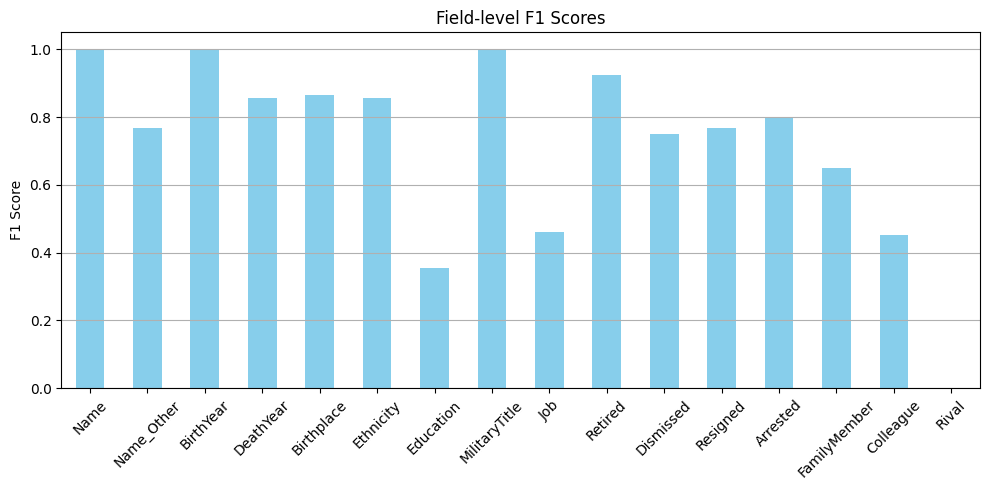

In [ ]:
# === Plot F1 Scores ===
import matplotlib.pyplot as plt
eval_field_df["F1"].plot(kind="bar", figsize=(10, 5), title="Field-level F1 Scores", color="skyblue")
plt.ylabel("F1 Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

In [ ]:
eval_sim_df

,Value
JSON_Valid (%),97.560
Exact_Match (%),4.880
Avg_Jaccard_Similarity (all),0.829
Avg_Cosine_Similarity (all),0.953
Avg_Jaccard_Similarity (valid_only),0.849
Avg_Cosine_Similarity (valid_only),0.976
Macro_Precision,0.735
Macro_Recall,0.718
Macro_F1,0.719
Unknown_Keys_Total,0.000


In [ ]:
eval_field_df

,Precision,Recall,F1,Hallucinated,Missed
Name,1.000,1.000,1.000,0,0
Name_Other,0.714,0.833,0.769,4,2
BirthYear,1.000,1.000,1.000,0,0
DeathYear,0.818,0.900,0.857,4,2
Birthplace,0.865,0.865,0.865,5,5
Ethnicity,1.000,0.750,0.857,0,1
Education,0.364,0.348,0.356,14,15
MilitaryTitle,1.000,1.000,1.000,0,0
Job,0.462,0.462,0.462,21,21
Retired,0.923,0.923,0.923,1,1


### Comparing With Other Models

*   Llama 3.1-8B-StructuredIE (finetune) - Already shown above
*   Llama 3.1-8B-StructuredIE (finetune + 1shot)
*   Llama 3.1-8B (vanila)
*   Llama 3.1-8B (constraint)
*   Llama 3.3-70B (vanila)
*   Llama 3.3-70B (constraint)





In [ ]:
from datasets import load_dataset
dataset_test = load_dataset("json", data_files="/content/drive/llm_train_2025.12.10_alpaca_testset.jsonl",
    split="train",   # <- key name in the DatasetDict
)

# Verify the split
print(dataset_test)

Dataset({
    features: ['input', 'output', 'text'],
    num_rows: 46
})


##### Llama 3.1-8B Finetuned + 1 Shot

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 9000 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = False # Use 4bit quantization to reduce memory usage. Can be False.

model_ft, tokenizer_ft = FastLanguageModel.from_pretrained(
    model_name = "tu-ericngo/llama-3.1-8B-StructuredIE-v2",   # unsloth/Meta-Llama-3.1-8B    (for vanila llama)
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Unsloth: Could not import trl.trainer.ddpo_trainer: Failed to import trl.trainer.ddpo_trainer because of the following error (look up to see its traceback):
Failed to import trl.models.modeling_sd_base because of the following error (look up to see its traceback):
Failed to import diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion because of the following error (look up to see its traceback):
Failed to import diffusers.loaders.ip_adapter because of the following error (look up to see its traceback):
JITCallable._set_src() takes 1 positional argument but 2 were given
Unsloth: Could not find Config class in trl.trainer.dpo_trainer. Found: []
Unsloth: Could not find Config class in trl.trainer.iterative_sft_trainer. Found: []
Unsloth: Could not find Config class in trl.trainer.sft_trainer. Found: []
==((====))==  Unsloth 2025.12.1: Fast Llam

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

In [ ]:
# ===== Set Prompt Format =====
import torch
import gc

short_instruction = (
    "Extract key biographical details from the following text and output them as structured JSON. The JSON output must follow the **structure and key names** below.\n\n"
    "{\"Name\": \"\", \"Name_Other\": [], \"BirthYear\": \"\", \"DeathYear\": \"\", "
    "\"Birthplace\": {\"City\": \"\", \"City_OtherName\": [], \"Region\": \"\",  \"Region_OtherName\": []}, "
    "\"Ethnicity\": [], "
    "\"Education\": [{\"School\": \"\", \"OtherName\": [], \"Start\": \"\", \"End\": \"\", "
    "\"Level\": \"\", \"Field\": \"\", \"Location\": []}], "
    "\"MilitaryTitle\": [{\"Title\": \"\", \"YearReceived\": \"\"}], "
    "\"Job\": [{\"Start\": \"\", \"End\": \"\", \"Position\": \"\", \"Location\": [], \"Org_Main_Name\": \"\", \"Org_Main_OtherName\": \"\", \"Org_Department\": \"\", \"Org_Unit\": \"\"}],"
    "\"Retired\": [{\"Date\": \"\", \"Detail\": []}], "
    "\"Dismissed\": [{\"Date\": \"\", \"Detail\": []}], "
    "\"Resigned\": [{\"Date\": \"\", \"Detail\": []}], "
    "\"Arrested\": [{\"Date\": \"\", \"Detail\": []}], "
    "\"Exiled\": [{\"Date\": \"\", \"Detail\": []}], "
    "\"Killed\": [{\"Date\": \"\", \"Detail\": []}], "
    "\"FamilyMember\": [{\"Name\": \"\", \"Relation\": \"\"}], "
    "\"Colleague\": [{\"FirstMention_Year\": \"\", \"Name\": []}], "
    "\"Rival\": [{\"FirstMention_Year\": \"\", \"Name\": []}]}\n\n"
    "Formatting Rules:\n"
    "- Use only the information in the biography.\n"
    "- **Do not fabricate or rename any JSON keys.** Use only the keys shown in the template.\n"
    "- **Preserve the exact structure of the JSON object**, including all nested levels.\n"
    "- If a **nested subfield** (e.g., \"OtherName\" under \"Education\" or \"Position\" under \"Job\") is missing, **include the key but leave it empty**.\n"
    "- If a **top-level JSON field** (e.g., \"DeathYear\", \"Exiled\", \"Rival\") has absolutely no information, **omit the entire field**.\n"
    "- **Do not add any fields or labels outside the JSON output**.\n"
    "- Your response must be a single JSON object only, with no additional text before or after.\n"
)

detailed_instruction = (
    "You are an expert historian and political scientist specializing in biographies of political elites. "
    "Below is an example of how to extract information from a biography and store it in a structured JSON.\n"
    "Example Biography and JSON Output\n"
    "**Example Biography:**\n"
    "To Huy Rua (born 1947) is a Vietnamese politician. He was a former Head of the Central Organization Committee, "
    "Director of the Ho Chi Minh National Academy of Politics, and Director of the Central Propaganda School. "
    "He has a university degree in Mathematics and a Doctorate in Philosophy.\n"
    "Biography\n"
    "He was born on June 4, 1947, in Quang Thai commune, Quang Xuong district, Thanh Hoa province.\n"
    "In 1965, he volunteered to serve in the battlefield in the Southern region until 1970, when he attended the Central Propaganda School (now the Academy of Journalism and Communication), majoring in Philosophy."
    "After graduating in 1974, he was retained as a teaching assistant at the school's Faculty of Philosophy. During his time as a teaching assistant, he registered for additional studies (1975–1979) and earned a Bachelor's degree in Mathematics at Hanoi University of Science (now Vietnam National University, Hanoi).\n"
    "In 1980, To Huy Rua was a postgraduate student in Philosophy at the Academy of Social Sciences of the USSR. After successfully defending his doctoral thesis in 1986, he returned to Vietnam and became Deputy Head of the Faculty of Philosophy, Hanoi University of Science (now Vietnam National University, Hanoi).\n"
    "From 1990 to 1995, he was selected Director of the Central Propaganda School. During this time, he was awarded the title of Associate Professor.\n"
    "At the end of 1999, he was appointed by his fellow countryman (same native province), General Secretary Le Kha Phieu, as Secretary of the Hai Phong City Party Committee, a position he began in 2000.\n"
    "At the 12th National Congress (January 2016) he retired.\n"
    "Family\n"
    "• His wife is Ms. Truong Tuyet Nhung, former Head of Training Department, Academy of Journalism and Propaganda.\n"
    "• First son: To Tu Ha, Director of Noi Bai International Airport.\n"
    "• Second son: To Huy Vu, currently Director of the International Cooperation Department of the State Bank of Vietnam.\n"
    "Controversial political activity\n"
    "To Huy Rua was reported to have sponsored the rise of Pham Van Vung to be a Navy Political Commissar. When he became "
    "Navy Political Commissar, Pham Van Vung was forced to hand over his position after one year in office due to his corrupt behavior.\n\n"
    "**Expected JSON Output:**\n"
    "{\"Name\": \"To Huy Rua\", "
    "\"Name_Other\": [], "
    "\"BirthYear\": \"1947\", "
    "\"Birthplace\": {\"City\": \"Quang Xuong\", \"City_OtherName\": [], \"Region\": \"Thanh Hoa\", \"Region_OtherName\": []}, "
    "\"Education\": ["
        "{\"School\": \"Central Propaganda School\", \"OtherName\": [\"Academy of Journalism and Communication\"], \"Start\": \"1970\", \"End\": \"1974\", \"Level\": \"\", \"Field\": \"\", \"Location\": []}, "
        "{\"School\": \"Hanoi University of Science\", \"OtherName\": [\"Vietnam National University, Hanoi\"], \"Start\": \"1975\", \"End\": \"1979\", \"Level\": \"University\", \"Field\": \"Mathematics\", \"Location\": [\"Hanoi\"]}, "
        "{\"School\": \"Academy of Social Sciences\", \"OtherName\": [], \"Start\": \"1980\", \"End\": \"1986\", \"Level\": \"Doctorate\", \"Field\": \"Philosophy\", \"Location\": [\"USSR\"]}"
    "], "
    "\"Job\": ["
        "{\"Start\": \"1965\", \"End\": \"1970\", \"Position\": \"Military Service\", \"Location\": [\"South\"], \"Org_Main_Name\": \"\", \"Org_Main_OtherName\": \"\", \"Org_Department\": \"\", \"Org_Unit\": \"\"},"
        "{\"Start\": \"1974\", \"End\": \"1979\", \"Position\": \"Teaching Assistant\", \"Location\": [], \"Org_Main_Name\": \"Central Propaganda School\", \"Org_Main_OtherName\": \"Academy of Journalism and Communication\", \"Org_Department\": \"\", \"Org_Unit\": \"\"}, "
        "{\"Start\": \"1986\", \"End\": \"\", \"Position\": \"Deputy Head\", \"Location\": [\"Hanoi\"], \"Org_Main_Name\": \"Hanoi University of Science\", \"Org_Main_OtherName\": \"Vietnam National University, Hanoi\", \"Org_Department\": \"Faculty of Philosophy\", \"Org_Unit\": \"\"}, "
        "{\"Start\": \"1990\", \"End\": \"1995\", \"Position\": \"Director\", \"Location\": [], \"Org_Main_Name\": \"Central Propaganda School\", \"Org_Main_OtherName\": \"\", \"Org_Department\": \"\", \"Org_Unit\": \"\"}, "
        "{\"Start\": \"2000\", \"End\": \"\", \"Position\": \"Secretary\", \"Location\": [\"Hai Phong\"], \"Org_Main_Name\": \"City Party Committee\", \"Org_Main_OtherName\": \"\", \"Org_Department\": \"\", \"Org_Unit\": \"\"}"
    "], "
    "\"Retired\": ["
        "{\"Date\": \"January 2016\", \"Detail\": [\"At the 12th National Congress (January 2016) he retired.\"]}"
    "], "
    "\"FamilyMember\": ["
        "{\"Name\": \"Truong Tuyet Nhung\", \"Relation\": \"Wife\"}, "
        "{\"Name\": \"To Tu Ha\", \"Relation\": \"Son\"}, "
        "{\"Name\": \"To Huy Vu\", \"Relation\": \"Son\"}"
    "], "
    "\"Colleague\": ["
        "{\"FirstMention_Year\": \"1999\", \"Name\": [\"Le Kha Phieu\"]}, "
        "{\"FirstMention_Year\": \"\", \"Name\": [\"Pham Van Vung\"]}"
    "]"
    "}\n\n"
    "Like the above example, your task is to generate a structured JSON record that captures key details of an elite's life, education, and career based on his/her biography. "
    "The JSON output must follow the **structure and key names** below.\n\n"
    "{\"Name\": \"\", \"Name_Other\": [], \"BirthYear\": \"\", \"DeathYear\": \"\", "
    "\"Birthplace\": {\"City\": \"\", \"City_OtherName\": [], \"Region\": \"\",  \"Region_OtherName\": []}, "
    "\"Ethnicity\": [], "
    "\"Education\": [{\"School\": \"\", \"OtherName\": [], \"Start\": \"\", \"End\": \"\", "
    "\"Level\": \"\", \"Field\": \"\", \"Location\": []}], "
    "\"MilitaryTitle\": [{\"Title\": \"\", \"YearReceived\": \"\"}], "
    "\"Job\": [{\"Start\": \"\", \"End\": \"\", \"Position\": \"\", \"Location\": [], \"Org_Main_Name\": \"\", \"Org_Main_OtherName\": \"\", \"Org_Department\": \"\", \"Org_Unit\": \"\"}],"
    "\"Retired\": [{\"Date\": \"\", \"Detail\": []}], "
    "\"Dismissed\": [{\"Date\": \"\", \"Detail\": []}], "
    "\"Resigned\": [{\"Date\": \"\", \"Detail\": []}], "
    "\"Arrested\": [{\"Date\": \"\", \"Detail\": []}], "
    "\"Exiled\": [{\"Date\": \"\", \"Detail\": []}], "
    "\"Killed\": [{\"Date\": \"\", \"Detail\": []}], "
    "\"FamilyMember\": [{\"Name\": \"\", \"Relation\": \"\"}], "
    "\"Colleague\": [{\"FirstMention_Year\": \"\", \"Name\": []}], "
    "\"Rival\": [{\"FirstMention_Year\": \"\", \"Name\": []}]}\n\n"
    "Formatting Rules:\n"
    "- Use only the information in the biography.\n"
    "- **Do not fabricate or rename any JSON keys.** Use only the keys shown in the template.\n"
    "- **Preserve the exact structure of the JSON object**, including all nested levels.\n"
    "- If a **nested subfield** (e.g., \"OtherName\" under \"Education\" or \"Position\" under \"Job\") is missing, **include the key but leave it empty**.\n"
    "- If a **top-level JSON field** (e.g., \"DeathYear\", \"Exiled\", \"Rival\") has absolutely no information, **omit the entire field**.\n"
    "- **Do not add any fields or labels outside the JSON output**.\n"
    "- Your response must be a single JSON object only, with no additional text before or after.\n"
)

alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""



In [ ]:
# ===== Inference on Test Set (FT + 1-Shot) =====
use_one_shot = True   # set to False to test zero-shot

predictions_ft1shot = []

for example in dataset_test:
    # choose instruction
    instruction = detailed_instruction if use_one_shot else short_instruction

    # format prompt
    prompt = alpaca_prompt.format(
        instruction,
        example["input"],
        ""
    )

    # tokenize
    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")

    # generate
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=1950,
            temperature=0.15,
            eos_token_id=tokenizer.eos_token_id,
        )

    # decode full text (prompt + response)
    output_decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

    # extract substring after "### Response:"
    response_start = output_decoded.find("### Response:")
    if response_start != -1:
        json_start = response_start + len("### Response:")
        prediction = output_decoded[json_start:].strip()
    else:
        prediction = output_decoded.strip()

    predictions_ft1shot.append({
        "input": example["input"],
        "expected_output": example["output"],
        "prediction": prediction,
    })

    del inputs, outputs
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
# === Save to File (finetune + 1 shot) ===
import json

output_path = "/content/test_pred_2025.12.12_ft1shot_opt2.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(predictions_ft1shot, f, ensure_ascii=False, indent=2)

print(f"✅ Saved predictions to {output_path}")

✅ Saved predictions to /content/drive/MyDrive/EliteNet_FineTunning/Finetune4_2025.12.10/test_pred_2025.12.12_ft1shot_opt2.json


In [ ]:
predictions[0]

{'input': "Viktor Fedorovich Yerin, a prominent Russian statesman, was born on January 17, 1944, in Kazan, Tatarstan region, and passed away on March 19, 2018, in Moscow. His distinguished career spanned several decades, during which he held various high-ranking positions in the Russian government. He is also known as Viktor Fyodorovich Erin, Viktor Erin, V. F. Erin, Viktor Yerin, or V. F. Yerin.\n\nYerin's professional journey began in 1960 when he worked as a toolmaker at the Kazan Aviation Plant named after Gorbunov. He pursued his education at the Kazan branch of the Yelabuga Secondary Police School, graduating with honors in 1967. He furthered his studies at the Higher School of the USSR Ministry of Internal Affairs, also graduating with honors in 1973.\n\nYerin's service in the internal affairs bodies commenced in 1964 as a district police officer of the Leninsky ROOOP in Kazan. He subsequently held various positions in the internal affairs bodies of Tatarstan, including operatio

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# ================== CONFIG ==================

# === Paths ===
predictions_path = "/content/test_pred_2025.12.12_ft1shot_opt2.json"
eval_sim_csv_path = "/content/eval_sim_ft1shot_opt2.csv"
eval_field_csv_path = "/content/eval_field_ft1shot_opt2.csv"
per_example_csv_path = "/content/per_example_eval_ft1shot_opt2.csv"

# --- Fields to evaluate (top-level schema) ---
fields_to_check = [
    "Name", "Name_Other", "BirthYear", "DeathYear", "Birthplace", "Ethnicity",
    "Education", "MilitaryTitle", "Job", "Retired", "Dismissed", "Resigned",
    "Arrested", # "Exiled", "Killed",
    "FamilyMember", "Colleague", "Rival",
]

ALLOWED_TOP_LEVEL = set(fields_to_check)

# --- Nested list-of-dicts fields where we want Jaccard + key-based matching ---
NESTED_LIST_FIELDS = {
    "Education", "Job", "Retired",
    "Dismissed", "Resigned", "Arrested", # "Exiled", "Killed",
    "Colleague", "Rival",
}

# For each nested field, define which keys inside each dict are "core" for matching.
# You should adjust these to your actual schema. For keys not listed here, all keys will be used.
CORE_KEYS_PER_FIELD = {
    "MilitaryTitle": ["Title", "YearReceived"],
    "Education":    ["School", "Start", "End", "Location"],
    "Job":          ["Start", "End", "Position", "Location", "Org_Main_Name", "Org_Department", "Org_Unit"],
    "Retired":      ["Date", "Reason"],
    "Dismissed":    ["Date", "Reason", "Organization"],
    "Resigned":     ["Date", "Reason", "Organization"],
    "Arrested":     ["Date", "Reason"],
    # "Exiled":       ["Date", "Reason", "Country"],
    # "Killed":       ["Date", "Cause", "Location"],
    "Colleague":    ["FirstMention_Year", "Name"],
    "Rival":        ["FirstMention_Year", "Name"],
}

# Jaccard threshold for considering a nested field as a "match" (TP)
NESTED_MATCH_THRESHOLD = 0.6

# ================== HELPERS ==================

def try_parse_json(s):
    try:
        return json.loads(s), True
    except Exception:
        return None, False

def flatten_json_fields_with_presence(json_obj):
    """
    Returns:
        flat:    dict[field_name -> string representation]
        present: dict[field_name -> bool] (whether the field key exists at top level)
    """
    flat = {}
    present = {}
    for field in fields_to_check:
        if field in json_obj:
            present[field] = True
            val = json_obj[field]
        else:
            present[field] = False
            val = None

        if isinstance(val, (list, dict)):
            flat[field] = json.dumps(val, sort_keys=True, ensure_ascii=False)
        elif val is None:
            flat[field] = ""
        else:
            flat[field] = str(val)
    return flat, present

def compute_cosine_sim(a, b):
    vec = TfidfVectorizer().fit_transform([a, b])
    return cosine_similarity(vec[0:1], vec[1:2])[0][0]

def compute_jaccard_sim(a, b):
    set1, set2 = set(a.split()), set(b.split())
    return len(set1 & set2) / len(set1 | set2) if (set1 | set2) else 1.0

def unknown_keys(json_obj):
    return [k for k in json_obj.keys() if k not in ALLOWED_TOP_LEVEL]

def _to_list(val):
    """Helper: normalize a field value to a list (or empty list)."""
    if val is None:
        return []
    if isinstance(val, str):
        try:
            parsed = json.loads(val)
            if isinstance(parsed, list):
                return parsed
            else:
                return []
        except Exception:
            return []
    if isinstance(val, list):
        return val
    return []

def _canon_dict(d, core_keys=None):
    """
    Canonicalize a dict to a JSON string using only core_keys (if provided).
    If core_keys is None, use the dict as-is.
    """
    if not isinstance(d, dict):
        return None
    if core_keys:
        core = {k: d.get(k) for k in core_keys if k in d}
    else:
        core = d
    return json.dumps(core, sort_keys=True, ensure_ascii=False)

def list_of_dicts_jaccard(pred_val, gold_val, field_name=None):
    """
    Compute Jaccard similarity between two list-of-dicts fields using only
    "core" keys specified for that field (if provided).
    """
    try:
        pred_list = _to_list(pred_val)
        gold_list = _to_list(gold_val)
        core_keys = CORE_KEYS_PER_FIELD.get(field_name, None)

        set_p = set()
        for item in pred_list:
            c = _canon_dict(item, core_keys=core_keys)
            if c is not None:
                set_p.add(c)

        set_g = set()
        for item in gold_list:
            c = _canon_dict(item, core_keys=core_keys)
            if c is not None:
                set_g.add(c)

        if not set_p and not set_g:
            return 1.0  # both empty → perfect Jaccard
        if not (set_p or set_g):
            return 0.0

        inter = len(set_p & set_g)
        union = len(set_p | set_g)
        return inter / union if union else 0.0
    except Exception:
        return 0.0

# ================== LOAD PREDICTIONS ==================

with open(predictions_path, "r", encoding="utf-8") as f:
    test_pred = json.load(f)

total = len(test_pred)

# ================== METRICS STRUCTURES ==================

fieldwise_scores = {
    f: {"tp": 0, "fp": 0, "fn": 0, "hallucinated": 0, "missed": 0}
    for f in fields_to_check
}

# For nested fields, track per-example Jaccard to report averages
nested_field_jaccards = {f: [] for f in NESTED_LIST_FIELDS}

json_valid_count = 0
exact_match_count = 0

cosine_sims_all = []
jaccard_sims_all = []
cosine_sims_valid = []
jaccard_sims_valid = []

unknown_key_total = 0

per_example_rows = []

# ================== MAIN EVAL LOOP ==================

for entry in test_pred:
    gold_json, gold_valid = try_parse_json(entry["expected_output"])
    pred_json, pred_valid = try_parse_json(entry["prediction"])

    json_valid_count += int(pred_valid)

    cos_sim = 0.0
    jac_sim = 0.0

    if (
        pred_valid and gold_valid
        and isinstance(gold_json, dict)
        and isinstance(pred_json, dict)
    ):
        # Exact JSON match
        exact_match = (pred_json == gold_json)
        exact_match_count += int(exact_match)

        flat_gold, gold_present = flatten_json_fields_with_presence(gold_json)
        flat_pred, pred_present = flatten_json_fields_with_presence(pred_json)

        # Similarities on concatenated text of all fields
        all_gold_text = " ".join(flat_gold.values())
        all_pred_text = " ".join(flat_pred.values())
        cos_sim = compute_cosine_sim(all_pred_text, all_gold_text)
        jac_sim = compute_jaccard_sim(all_pred_text, all_gold_text)

        cosine_sims_valid.append(cos_sim)
        jaccard_sims_valid.append(jac_sim)

        # Unknown keys
        unknowns = unknown_keys(pred_json)
        unknown_key_total += len(unknowns)

        # Per-field metrics
        for f in fields_to_check:
            g_has = gold_present[f]
            p_has = pred_present[f]

            # CASE 1: field absent as a key in both → ignore (no free TP)
            if not g_has and not p_has:
                continue

            # Nested list-of-dicts fields: use Jaccard + key-based matching
            if f in NESTED_LIST_FIELDS:
                g_raw = gold_json.get(f, None)
                p_raw = pred_json.get(f, None)

                g_list = _to_list(g_raw)
                p_list = _to_list(p_raw)

                g_empty = len(g_list) == 0
                p_empty = len(p_list) == 0

                # Track Jaccard for analysis (even if empty)
                j_nested = list_of_dicts_jaccard(p_raw, g_raw, field_name=f)
                nested_field_jaccards[f].append(j_nested)

                # CASE N1: both lists empty → ignore this example for this field
                if g_empty and p_empty:
                    continue

                # CASE N2: gold has content, pred has none
                if (not g_empty) and p_empty:
                    fieldwise_scores[f]["fn"] += 1
                    fieldwise_scores[f]["missed"] += 1
                    continue

                # CASE N3: pred has content, gold has none
                if g_empty and (not p_empty):
                    fieldwise_scores[f]["fp"] += 1
                    fieldwise_scores[f]["hallucinated"] += 1
                    continue

                # CASE N4: both have non-empty lists → use Jaccard threshold
                if j_nested >= NESTED_MATCH_THRESHOLD:
                    fieldwise_scores[f]["tp"] += 1
                else:
                    fieldwise_scores[f]["fp"] += 1
                    fieldwise_scores[f]["fn"] += 1
                    fieldwise_scores[f]["hallucinated"] += 1
                    fieldwise_scores[f]["missed"] += 1

            else:
                # Non-nested fields: use stricter equality + presence

                g_val = flat_gold[f]   # string
                p_val = flat_pred[f]   # string

                # CASE S1: both keys present
                if g_has and p_has:
                    if g_val == p_val:
                        fieldwise_scores[f]["tp"] += 1
                    else:
                        fieldwise_scores[f]["fp"] += 1
                        fieldwise_scores[f]["fn"] += 1
                        fieldwise_scores[f]["hallucinated"] += 1
                        fieldwise_scores[f]["missed"] += 1

                # CASE S2: gold has field, pred omits it
                elif g_has and not p_has:
                    fieldwise_scores[f]["fn"] += 1
                    fieldwise_scores[f]["missed"] += 1

                # CASE S3: pred has field, gold omits it
                elif p_has and not g_has:
                    fieldwise_scores[f]["fp"] += 1
                    fieldwise_scores[f]["hallucinated"] += 1

    # If invalid JSON on either side:
    cosine_sims_all.append(cos_sim)
    jaccard_sims_all.append(jac_sim)

    per_example_rows.append({
        "input": entry["input"],
        "expected_output": entry["expected_output"],
        "prediction": entry["prediction"],
        "gold_json_valid": gold_valid,
        "pred_json_valid": pred_valid,
        "cosine_all": cos_sim,
        "jaccard_all": jac_sim,
    })

# ================== AGGREGATE METRICS ==================

field_metrics = {}
for f in fields_to_check:
    scores = fieldwise_scores[f]
    tp, fp, fn = scores["tp"], scores["fp"], scores["fn"]
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tp / (tp + fn) if (tp + fn) else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0.0
    field_metrics[f] = {
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1": round(f1, 3),
        "Hallucinated": scores["hallucinated"],
        "Missed": scores["missed"],
    }

# Macro averages
macro_precision = sum(m["Precision"] for m in field_metrics.values()) / len(field_metrics)
macro_recall    = sum(m["Recall"] for m in field_metrics.values()) / len(field_metrics)
macro_f1        = sum(m["F1"] for m in field_metrics.values()) / len(field_metrics)

# Overall similarities
evaluation_sim = {
    "JSON_Valid (%)": round(json_valid_count / total * 100, 2),
    "Exact_Match (%)": round(exact_match_count / total * 100, 2),
    "Avg_Jaccard_Similarity (all)": round(sum(jaccard_sims_all) / total, 3),
    "Avg_Cosine_Similarity (all)": round(sum(cosine_sims_all) / total, 3),
    "Avg_Jaccard_Similarity (valid_only)": round(
        sum(jaccard_sims_valid) / len(jaccard_sims_valid), 3
    ) if jaccard_sims_valid else 0.0,
    "Avg_Cosine_Similarity (valid_only)": round(
        sum(cosine_sims_valid) / len(cosine_sims_valid), 3
    ) if cosine_sims_valid else 0.0,
    "Macro_Precision": round(macro_precision, 3),
    "Macro_Recall": round(macro_recall, 3),
    "Macro_F1": round(macro_f1, 3),
    "Unknown_Keys_Total": unknown_key_total,
    "Unknown_Keys_per_Doc": round(unknown_key_total / total, 3),
}

# Add per-field average Jaccard for nested fields
for f in NESTED_LIST_FIELDS:
    vals = nested_field_jaccards.get(f, [])
    key_name = f"Avg_{f}_Jaccard"
    evaluation_sim[key_name] = round(sum(vals) / len(vals), 3) if vals else 0.0

# ================== SAVE TO CSV ==================

eval_sim_df = pd.DataFrame.from_dict(evaluation_sim, orient="index", columns=["Value"])
eval_field_df = pd.DataFrame.from_dict(field_metrics, orient="index")
per_example_df = pd.DataFrame(per_example_rows)

eval_sim_df.to_csv(eval_sim_csv_path)
eval_field_df.to_csv(eval_field_csv_path)
per_example_df.to_csv(per_example_csv_path, index=False)

print("Saved:")
print("  -", eval_sim_csv_path)
print("  -", eval_field_csv_path)
print("  -", per_example_csv_path)


Saved:
  - /content/drive/MyDrive/EliteNet_FineTunning/Finetune4_2025.12.10/eval_sim_ft1shot_opt2.csv
  - /content/drive/MyDrive/EliteNet_FineTunning/Finetune4_2025.12.10/eval_field_ft1shot_opt2.csv
  - /content/drive/MyDrive/EliteNet_FineTunning/Finetune4_2025.12.10/per_example_eval_ft1shot_opt2.csv


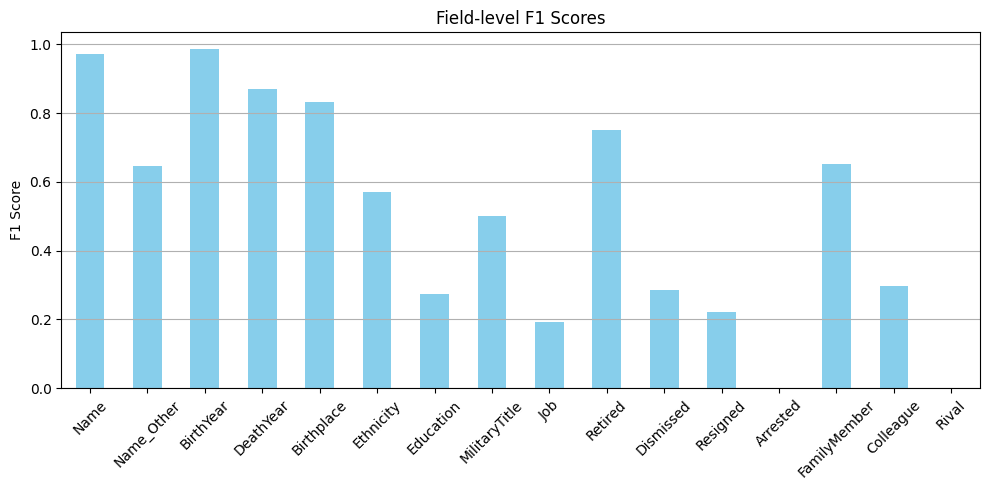

In [ ]:
# === Plot F1 Scores (finetune + 1 shot) ===
eval_field_df["F1"].plot(kind="bar", figsize=(10, 5), title="Field-level F1 Scores", color="skyblue")
plt.ylabel("F1 Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

In [ ]:
eval_sim_df

,Value
JSON_Valid (%),90.240
Exact_Match (%),0.000
Avg_Jaccard_Similarity (all),0.665
Avg_Cosine_Similarity (all),0.829
Avg_Jaccard_Similarity (valid_only),0.737
Avg_Cosine_Similarity (valid_only),0.918
Macro_Precision,0.495
Macro_Recall,0.531
Macro_F1,0.503
Unknown_Keys_Total,3.000


#### Llama 3.3 70B (1 shot)
Distilabel + Together AI

In [ ]:
!pip install distilabel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.2/511.2 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 13.8 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.0
    Uninstalling fsspec-2025.3.0:
      Successfully uninstalled fsspec-2025.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.0 requires fsspec==2025.3.0, but you have fsspec 2024.12.0 which is incompatible.
torch 2

In [ ]:
# Load the Llama model
from distilabel.models.llms import TogetherLLM

llama_model = TogetherLLM(model="meta-llama/Llama-3.3-70B-Instruct-Turbo",
                         api_key="c86ec6d487a6c82baa2ea6b0b5e3432384f82c36a7c09111a5e09494357058e4")

# Check if initialization is successful
if llama_model is None:
    print("❌ ERROR: Model initialization failed!")
else:
    print("✅ Model initialized successfully.")

# Check if the model loads successfully
try:
    llama_model.load()
    print("✅ Model loaded successfully.")
except Exception as e:
    print(f"❌ ERROR: Model failed to load! \n{e}")

✅ Model initialized successfully.
✅ Model loaded successfully.


In [ ]:

# Helper: Fixed JSON structure (template) for formatting prompt
json_schema = """
{"Name": "", "Name_Other": [], "BirthYear": "", "DeathYear": "", "Birthplace": {"City": "", "City_OtherName": [], "Region": "",  "Region_OtherName": []}, "Ethnicity": [], "Education": [{ "School": "", "OtherName": [], "Start": "", "End": "", "Level": "", "Field": "", "Location": []}], "MilitaryTitle": [{"Title": "", "YearReceived": ""}], "Job": [{"Start": "", "End": "", "Position": "", "Organization": {"MainOrg": "", "MainOrg_OtherName": "", "SubOrg": "", "Unit": ""}, "Location": []}], "Retired": [{"Date": "", "Detail": []}], "Dismissed": [{"Date": "", "Detail": []}], "Resigned": [{"Date": "", "Detail": []}], "Arrested": [{"Date": "", "Detail": []}], "Exiled": [{"Date": "", "Detail": []}], "Killed": [{"Date": "", "Detail": []}], "FamilyMember": [{"Name": "", "Relation": ""}], "Colleague": [{"FirstMention_Year": "", "Name": []}], "Rival": [{"FirstMention_Year": "", "Name": []}]}
"""

json_example = """
{
  "Name": "To Huy Rua",
  "Name_Other": [],
  "BirthYear": "1947",
  "Birthplace": {"City": "Quang Xuong", "City_OtherName": [], "Region": "Thanh Hoa",  "Region_OtherName": []},
  "Education": [
    {"School": "Central Propaganda School", "OtherName": ["Academy of Journalism and Communication"], "Start": "1970", "End": "1974", "Level": "", "Field": "", "Location": []},
    {"School": "Hanoi University of Science", "OtherName": ["Vietnam National University, Hanoi"], "Start": "1975", "End": "1979", "Level": "University", "Field": "Mathematics", "Location": ["Hanoi"]},
    {"School": "Academy of Social Sciences", "OtherName": [], "Start": "1980", "End": "1986", "Level": "Doctorate", "Field": "Philosophy", "Location": ["USSR"]}
      ],
  "Job": [
    {"Start": "1965", "End": "1970", "Position": "Military Service", "Organization": {"MainOrg": "", "MainOrg_OtherName": "", "SubOrg": "", "Unit": ""}, "Location": ["South"]},
    {"Start": "1974", "End": "1979", "Position": "Teaching Assistant", "Organization": {"MainOrg": "Central Propaganda School", "MainOrg_OtherName": "Academy of Journalism and Communication", "SubOrg": "", "Unit": ""}, "Location": []},
    {"Start": "1986", "End": "", "Position": "Deputy Head", "Organization": {"MainOrg": "Hanoi University of Science", "MainOrg_OtherName": "Vietnam National University, Hanoi", "SubOrg": "Faculty of Philisophy", "Unit": ""}, "Location": ["Hanoi"]},
    {"Start": "1990", "End": "1995", "Position": "Director", "Organization": {"MainOrg": "Central Propaganda School", "MainOrg_OtherName": "", "SubOrg": "", "Unit": ""}, "Location": []},
    {"Start": "2000", "End": "", "Position": "Secretary", "Organization": {"MainOrg": "City Party Committee", "MainOrg_OtherName": "", "SubOrg": "", "Unit": ""}, "Location": ["Hai Phong"]},
    {"Start": "2005", "End": "", "Position": "Director", "Organization": {"MainOrg": "Ho Chi Minh National Academy of Politics and Public Administration", "MainOrg_OtherName": "Ho Chi Minh National Academy of Politics", "SubOrg": "", "Unit": ""}, "Location": []}
    ],
  "Retired": [{"Date": "January 2016", "Detail": ["At the 12th National Congress (January 2016) he retired."]}],
  "FamilyMember": [{"Name": "Truong Tuyet Nhung", "Relation": "Wife"}, {"Name": "To Tu Ha", "Relation": "Son"}, {"Name": "To Huy Vu", "Relation": "Son"}],
  "Colleague": [{"FirstMention_Year": "1999", "Name": ["Le Kha Phieu"]}, {"FirstMention_Year": "", "Name": ["Pham Van Vung"]}]
}
"""

# Template for each input
def build_prompt(biography_text):
    return f"""
You are an expert historian and political scientist specializing in biographies of political elites. Below is an example of how to extract information from a biography and store them in JSON structure.
### Here is an Example Biography and Example JSON Output:
**Example Biography:**
To Huy Rua (born 1947) is a Vietnamese politician. He was a former Head of the Central Organization Committee , Director of the Ho Chi Minh National Academy of Politics , and Director of the Central Propaganda School. He has a university degree in Mathematics and a Doctorate in Philosophy. [ 1 ]
Biography
He was born on June 4, 1947, in Quang Thai commune, Quang Xuong district , Thanh Hoa province .
In 1965, he volunteered to serve in the battlefield in the Southern region until 1970, when he attended the Central Propaganda School (now the Academy of Journalism and Communication), majoring in Philosophy. After graduating in 1974, he was retained as a teaching assistant at the school's Faculty of Philosophy. During his time as a teaching assistant, he registered for additional studies (1975 – 1979) and earned a Bachelor's degree in Mathematics at Hanoi University of Science (now Vietnam National University, Hanoi).
In 1980, To Huy Rua was a postgraduate student in Philosophy at the Academy of Social Sciences of the USSR. After successfully defending doctoral thesis in 1986, he returned to Vietnam and became Deputy Head of the Faculty of Philosophy, Hanoi University of Science (now Vietnam National University, Hanoi).
From 1990 to 1995, he was selected Director of the Central Propaganda School. During this time, he was awarded the title of Associate Professor.
At the end of 1999, he was appointed by his fellow countryman (similar native province), General Secretary (of the CPV) Le Kha Phieu, as Secretary of the Hai Phong City Party Committee, a position he began in 2000.
At the end of 2004, he was appointed Director of the Ho Chi Minh National Academy of Politics and Public Administration (also known as the Ho Chi Minh National Academy of Politics) and occupied this position since 2005.
At the 12th National Congress (January 2016) he retired.
Family
• His wife is Ms. Truong Tuyet Nhung, former Head of Training Department, Academy of Journalism and Propaganda.
• First son: To Tu Ha, Director of Noi Bai International Airport.
• Second son: To Huy Vu, currently Director of the International Cooperation Department of the State Bank of Vietnam.
Controversial political activity
To Huy Rua was reported to having sponsored the rise of Pham Van Vung to be a Navy Political Commissar. When he became Navy Political Commissar, Pham Van Vung was forced to hand over his position after 1 year in office due to his corrupt behavior.

**Expected JSON Output:**
{json_example}

### Task:
Your task is to generate a structured JSON record that captures key details of an elite's life, education, and career based on his/her biography below.

**Biography:**
{biography_text}

The JSON output must follow the **structure and key names** below.

{json_schema}

Formatting Rules:
- Use only the information in the biography.
- **Do not fabricate or rename any JSON keys.** Use only the fields and labels shown in the template.
- **Preserve the exact structure of the JSON object**, including all nested levels.
- If a **nested subfield** (e.g., "OtherName" under "Education") is missing, **include the key but leave it empty**.
- If a **top-level JSON field** (e.g., "DeathYear", "Exiled", "Rival") has absolutely no information, **omit the entire top-level field**.
"""



In [ ]:
from datasets import load_dataset
from distilabel.models import TogetherLLM
from tqdm import tqdm

# Run inference over the full dataset
predictions = []
for example in tqdm(dataset_test):
    biography_text = example["input"]
    full_prompt = build_prompt(biography_text)

    output = llama_model.generate_outputs(
        inputs=[[{"role": "user", "content": full_prompt}]],
        max_new_tokens=2200,
        temperature=0.15
    )

    predicted_json = output[0]['generations'][0]
    predictions.append({
        "input": example["input"],
        "expected_output": example["output"],
        "prediction": predicted_json
    })


100%|██████████| 37/37 [02:25<00:00,  3.92s/it]


In [ ]:
import json
output_path = "/content/drive/MyDrive/EliteNet_FineTunning/Finetune3/test_preds_2025.03.26_llama70B_1shot.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(predictions, f, ensure_ascii=False, indent=2)

print(f"✅ Saved predictions to {output_path}")

✅ Saved predictions to /content/drive/MyDrive/EliteNet_FineTunning/Finetune3/test_preds_2025.03.26_llama70B_1shot.json


In [ ]:
predictions[0]

{'input': "Viktor Fedorovich Yerin, a prominent Russian statesman, was born on January 17, 1944, in Kazan, Tatarstan region, and passed away on March 19, 2018, in Moscow. His distinguished career spanned several decades, during which he held various high-ranking positions in the Russian government. He is also known as Viktor Fyodorovich Erin, Viktor Erin, V. F. Erin, Viktor Yerin, or V. F. Yerin.\n\nYerin's professional journey began in 1960 when he worked as a toolmaker at the Kazan Aviation Plant named after Gorbunov. He pursued his education at the Kazan branch of the Yelabuga Secondary Police School, graduating with honors in 1967. He furthered his studies at the Higher School of the USSR Ministry of Internal Affairs, also graduating with honors in 1973.\n\nYerin's service in the internal affairs bodies commenced in 1964 as a district police officer of the Leninsky ROOOP in Kazan. He subsequently held various positions in the internal affairs bodies of Tatarstan, including operatio

In [ ]:
# === Evaluate (llama 70B 1 shot) ===
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# === Load predictions ===
predictions_path = "/content/drive/MyDrive/EliteNet_FineTunning/Finetune3/test_preds_2025.03.26_llama70B_1shot.json"
with open(predictions_path, "r", encoding="utf-8") as f:
    test_pred_70B_1shot = json.load(f)

# === Fields to evaluate ===
fields_to_check = ["Name", "OtherName", "BirthYear", "DeathYear", "Birthplace", "Education", "MilitaryTitle", "Job", "Retired", "Dismissed", "Resigned", "Arrested", "Exiled", "Killed", "FamilyMember", "Colleague", "Rival"]

# === Helpers ===
def try_parse_json(s):
    try:
        return json.loads(s), True
    except json.JSONDecodeError:
        return None, False

def flatten_json_fields(json_obj):
    flat = {}
    for field in fields_to_check:
        val = json_obj.get(field, "")
        if isinstance(val, (list, dict)):
            flat[field] = json.dumps(val, sort_keys=True, ensure_ascii=False)
        else:
            flat[field] = str(val)
    return flat

def compute_cosine_sim(a, b):
    vec = TfidfVectorizer().fit_transform([a, b])
    return cosine_similarity(vec[0:1], vec[1:2])[0][0]

def compute_jaccard_sim(a, b):
    set1, set2 = set(a.split()), set(b.split())
    return len(set1 & set2) / len(set1 | set2) if (set1 | set2) else 1.0

def partial_match_nested_lists(pred_field, gold_field):
    try:
        pred_list = json.loads(pred_field) if isinstance(pred_field, str) else pred_field
        gold_list = json.loads(gold_field) if isinstance(gold_field, str) else gold_field
        if not isinstance(pred_list, list) or not isinstance(gold_list, list):
            return False
        return any(item in pred_list for item in gold_list)
    except Exception:
        return False

# === Initialize Metrics ===
results = []
fieldwise_scores = {
    f: {"tp": 0, "fp": 0, "fn": 0, "hallucinated": 0, "missed": 0}
    for f in fields_to_check
}
json_valid_count = 0
exact_match_count = 0
cosine_sims = []
jaccard_sims = []

for entry in test_pred_70B_1shot:
    gold_json, gold_valid = try_parse_json(entry["expected_output"])
    pred_json, pred_valid = try_parse_json(entry["prediction"])

    json_valid_count += int(pred_valid)

    if pred_valid and gold_valid:
        exact_match = pred_json == gold_json
        exact_match_count += int(exact_match)

        flat_gold = flatten_json_fields(gold_json)
        flat_pred = flatten_json_fields(pred_json)

        # Similarities on full text
        all_gold_text = " ".join(flat_gold.values())
        all_pred_text = " ".join(flat_pred.values())
        cosine_sims.append(compute_cosine_sim(all_pred_text, all_gold_text))
        jaccard_sims.append(compute_jaccard_sim(all_pred_text, all_gold_text))

        for f in fields_to_check:
            g_val = flat_gold[f]
            p_val = flat_pred[f]

            if g_val == p_val:
                fieldwise_scores[f]["tp"] += 1
            elif f in ["Job", "Education"] and partial_match_nested_lists(p_val, g_val):
                fieldwise_scores[f]["tp"] += 1  # Accept partial nested match
            else:
                if p_val:
                    fieldwise_scores[f]["fp"] += 1
                    fieldwise_scores[f]["hallucinated"] += 1
                if g_val:
                    fieldwise_scores[f]["fn"] += 1
                    fieldwise_scores[f]["missed"] += 1
    else:
        cosine_sims.append(0)
        jaccard_sims.append(0)

# === Compute per-field metrics ===
field_metrics_70B_1shot = {}
for f in fields_to_check:
    scores = fieldwise_scores[f]
    tp, fp, fn = scores["tp"], scores["fp"], scores["fn"]
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tp / (tp + fn) if (tp + fn) else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0.0
    field_metrics_70B_1shot[f] = {
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1": round(f1, 3),
        "Hallucinated": scores["hallucinated"],
        "Missed": scores["missed"]
    }

# === Overall metrics ===
total = len(test_pred_70B_1shot)
evaluation_sim_70B_1shot = {
    "JSON_Valid (%)": round(json_valid_count / total * 100, 2),
    "Exact_Match (%)": round(exact_match_count / total * 100, 2),
    "Avg_Jaccard_Similarity": round(sum(jaccard_sims) / total, 3),
    "Avg_Cosine_Similarity": round(sum(cosine_sims) / total, 3),
}

# === Output DataFrames ===
eval_sim_df_70B_1shot = pd.DataFrame.from_dict(evaluation_sim_70B_1shot, orient="index", columns=["Value"])
eval_field_df_70B_1shot = pd.DataFrame.from_dict(field_metrics_70B_1shot, orient="index")

# === Save CSVs ===
eval_sim_df_70B_1shot.to_csv("/content/drive/MyDrive/EliteNet_FineTunning/Finetune3/eval_sim_finetune3_llama70B_1shot.csv")
eval_field_df_70B_1shot.to_csv("/content/drive/MyDrive/EliteNet_FineTunning/Finetune3/eval_field_finetune3_llama70B_1shot.csv")

print("✅ Evaluation complete. CSVs saved.")


✅ Evaluation complete. CSVs saved.


##### Llama Finetuned + 1 Shot

In [ ]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 9000 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = False # Use 4bit quantization to reduce memory usage. Can be False.

model_ft, tokenizer_ft = FastLanguageModel.from_pretrained(
    model_name = "tu-ericngo/llama-3.1-8B-StructuredIE-v2",   # unsloth/Meta-Llama-3.1-8B    (for vanila llama)
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
Unsloth: Could not import trl.trainer.ddpo_trainer: Failed to import trl.trainer.ddpo_trainer because of the following error (look up to see its traceback):
Failed to import trl.models.modeling_sd_base because of the following error (look up to see its traceback):
Failed to import diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion because of the following error (look up to see its traceback):
Failed to import diffusers.loaders.ip_adapter because of the following error (look up to see its traceback):
JITCallable._set_src() takes 1 positional argument but 2 were given
Unsloth: Could not find Config class in trl.trainer.dpo_trainer. Found: []
Unsloth: Could not find Config class in trl.trainer.iterative_sft_trainer. Found: []
Unsloth: Could not find Config class in trl.trainer.sft_trainer. Found: []
==((====))==  Unsloth 2025.12.1: Fast Llam

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

chat_template.jinja: 0.00B [00:00, ?B/s]

In [ ]:
# ===== Set Prompt Format =====
import torch
import gc

short_instruction = (
    "Extract key biographical details from the following text and output them as structured JSON. The JSON output must follow the **structure and key names** below.\n\n"
    "{\"Name\": \"\", \"Name_Other\": [], \"BirthYear\": \"\", \"DeathYear\": \"\", "
    "\"Birthplace\": {\"City\": \"\", \"City_OtherName\": [], \"Region\": \"\",  \"Region_OtherName\": []}, "
    "\"Ethnicity\": [], "
    "\"Education\": [{\"School\": \"\", \"OtherName\": [], \"Start\": \"\", \"End\": \"\", "
    "\"Level\": \"\", \"Field\": \"\", \"Location\": []}], "
    "\"MilitaryTitle\": [{\"Title\": \"\", \"YearReceived\": \"\"}], "
    "\"Job\": [{\"Start\": \"\", \"End\": \"\", \"Position\": \"\", \"Location\": [], \"Org_Main_Name\": \"\", \"Org_Main_OtherName\": \"\", \"Org_Department\": \"\", \"Org_Unit\": \"\"}],"
    "\"Retired\": [{\"Date\": \"\", \"Detail\": []}], "
    "\"Dismissed\": [{\"Date\": \"\", \"Detail\": []}], "
    "\"Resigned\": [{\"Date\": \"\", \"Detail\": []}], "
    "\"Arrested\": [{\"Date\": \"\", \"Detail\": []}], "
    "\"Exiled\": [{\"Date\": \"\", \"Detail\": []}], "
    "\"Killed\": [{\"Date\": \"\", \"Detail\": []}], "
    "\"FamilyMember\": [{\"Name\": \"\", \"Relation\": \"\"}], "
    "\"Colleague\": [{\"FirstMention_Year\": \"\", \"Name\": []}], "
    "\"Rival\": [{\"FirstMention_Year\": \"\", \"Name\": []}]}\n\n"
    "Formatting Rules:\n"
    "- Use only the information in the biography.\n"
    "- **Do not fabricate or rename any JSON keys.** Use only the keys shown in the template.\n"
    "- **Preserve the exact structure of the JSON object**, including all nested levels.\n"
    "- If a **nested subfield** (e.g., \"OtherName\" under \"Education\" or \"Position\" under \"Job\") is missing, **include the key but leave it empty**.\n"
    "- If a **top-level JSON field** (e.g., \"DeathYear\", \"Exiled\", \"Rival\") has absolutely no information, **omit the entire field**.\n"
    "- **Do not add any fields or labels outside the JSON output**.\n"
    "- Your response must be a single JSON object only, with no additional text before or after.\n"
)

detailed_instruction = (
    "You are an expert historian and political scientist specializing in biographies of political elites. "
    "Below is an example of how to extract information from a biography and store it in a structured JSON.\n"
    "Example Biography and JSON Output\n"
    "**Example Biography:**\n"
    "To Huy Rua (born 1947) is a Vietnamese politician. He was a former Head of the Central Organization Committee, "
    "Director of the Ho Chi Minh National Academy of Politics, and Director of the Central Propaganda School. "
    "He has a university degree in Mathematics and a Doctorate in Philosophy.\n"
    "Biography\n"
    "He was born on June 4, 1947, in Quang Thai commune, Quang Xuong district, Thanh Hoa province.\n"
    "In 1965, he volunteered to serve in the battlefield in the Southern region until 1970, when he attended the Central Propaganda School (now the Academy of Journalism and Communication), majoring in Philosophy."
    "After graduating in 1974, he was retained as a teaching assistant at the school's Faculty of Philosophy. During his time as a teaching assistant, he registered for additional studies (1975–1979) and earned a Bachelor's degree in Mathematics at Hanoi University of Science (now Vietnam National University, Hanoi).\n"
    "In 1980, To Huy Rua was a postgraduate student in Philosophy at the Academy of Social Sciences of the USSR. After successfully defending his doctoral thesis in 1986, he returned to Vietnam and became Deputy Head of the Faculty of Philosophy, Hanoi University of Science (now Vietnam National University, Hanoi).\n"
    "From 1990 to 1995, he was selected Director of the Central Propaganda School. During this time, he was awarded the title of Associate Professor.\n"
    "At the end of 1999, he was appointed by his fellow countryman (same native province), General Secretary Le Kha Phieu, as Secretary of the Hai Phong City Party Committee, a position he began in 2000.\n"
    "At the 12th National Congress (January 2016) he retired.\n"
    "Family\n"
    "• His wife is Ms. Truong Tuyet Nhung, former Head of Training Department, Academy of Journalism and Propaganda.\n"
    "• First son: To Tu Ha, Director of Noi Bai International Airport.\n"
    "• Second son: To Huy Vu, currently Director of the International Cooperation Department of the State Bank of Vietnam.\n"
    "Controversial political activity\n"
    "To Huy Rua was reported to have sponsored the rise of Pham Van Vung to be a Navy Political Commissar. When he became "
    "Navy Political Commissar, Pham Van Vung was forced to hand over his position after one year in office due to his corrupt behavior.\n\n"
    "**Expected JSON Output:**\n"
    "{\"Name\": \"To Huy Rua\", "
    "\"Name_Other\": [], "
    "\"BirthYear\": \"1947\", "
    "\"Birthplace\": {\"City\": \"Quang Xuong\", \"City_OtherName\": [], \"Region\": \"Thanh Hoa\", \"Region_OtherName\": []}, "
    "\"Education\": ["
        "{\"School\": \"Central Propaganda School\", \"OtherName\": [\"Academy of Journalism and Communication\"], \"Start\": \"1970\", \"End\": \"1974\", \"Level\": \"\", \"Field\": \"\", \"Location\": []}, "
        "{\"School\": \"Hanoi University of Science\", \"OtherName\": [\"Vietnam National University, Hanoi\"], \"Start\": \"1975\", \"End\": \"1979\", \"Level\": \"University\", \"Field\": \"Mathematics\", \"Location\": [\"Hanoi\"]}, "
        "{\"School\": \"Academy of Social Sciences\", \"OtherName\": [], \"Start\": \"1980\", \"End\": \"1986\", \"Level\": \"Doctorate\", \"Field\": \"Philosophy\", \"Location\": [\"USSR\"]}"
    "], "
    "\"Job\": ["
        "{\"Start\": \"1965\", \"End\": \"1970\", \"Position\": \"Military Service\", \"Location\": [\"South\"], \"Org_Main_Name\": \"\", \"Org_Main_OtherName\": \"\", \"Org_Department\": \"\", \"Org_Unit\": \"\"},"
        "{\"Start\": \"1974\", \"End\": \"1979\", \"Position\": \"Teaching Assistant\", \"Location\": [], \"Org_Main_Name\": \"Central Propaganda School\", \"Org_Main_OtherName\": \"Academy of Journalism and Communication\", \"Org_Department\": \"\", \"Org_Unit\": \"\"}, "
        "{\"Start\": \"1986\", \"End\": \"\", \"Position\": \"Deputy Head\", \"Location\": [\"Hanoi\"], \"Org_Main_Name\": \"Hanoi University of Science\", \"Org_Main_OtherName\": \"Vietnam National University, Hanoi\", \"Org_Department\": \"Faculty of Philosophy\", \"Org_Unit\": \"\"}, "
        "{\"Start\": \"1990\", \"End\": \"1995\", \"Position\": \"Director\", \"Location\": [], \"Org_Main_Name\": \"Central Propaganda School\", \"Org_Main_OtherName\": \"\", \"Org_Department\": \"\", \"Org_Unit\": \"\"}, "
        "{\"Start\": \"2000\", \"End\": \"\", \"Position\": \"Secretary\", \"Location\": [\"Hai Phong\"], \"Org_Main_Name\": \"City Party Committee\", \"Org_Main_OtherName\": \"\", \"Org_Department\": \"\", \"Org_Unit\": \"\"}"
    "], "
    "\"Retired\": ["
        "{\"Date\": \"January 2016\", \"Detail\": [\"At the 12th National Congress (January 2016) he retired.\"]}"
    "], "
    "\"FamilyMember\": ["
        "{\"Name\": \"Truong Tuyet Nhung\", \"Relation\": \"Wife\"}, "
        "{\"Name\": \"To Tu Ha\", \"Relation\": \"Son\"}, "
        "{\"Name\": \"To Huy Vu\", \"Relation\": \"Son\"}"
    "], "
    "\"Colleague\": ["
        "{\"FirstMention_Year\": \"1999\", \"Name\": [\"Le Kha Phieu\"]}, "
        "{\"FirstMention_Year\": \"\", \"Name\": [\"Pham Van Vung\"]}"
    "]"
    "}\n\n"
    "Like the above example, your task is to generate a structured JSON record that captures key details of an elite's life, education, and career based on his/her biography. "
    "The JSON output must follow the **structure and key names** below.\n\n"
    "{\"Name\": \"\", \"Name_Other\": [], \"BirthYear\": \"\", \"DeathYear\": \"\", "
    "\"Birthplace\": {\"City\": \"\", \"City_OtherName\": [], \"Region\": \"\",  \"Region_OtherName\": []}, "
    "\"Ethnicity\": [], "
    "\"Education\": [{\"School\": \"\", \"OtherName\": [], \"Start\": \"\", \"End\": \"\", "
    "\"Level\": \"\", \"Field\": \"\", \"Location\": []}], "
    "\"MilitaryTitle\": [{\"Title\": \"\", \"YearReceived\": \"\"}], "
    "\"Job\": [{\"Start\": \"\", \"End\": \"\", \"Position\": \"\", \"Location\": [], \"Org_Main_Name\": \"\", \"Org_Main_OtherName\": \"\", \"Org_Department\": \"\", \"Org_Unit\": \"\"}],"
    "\"Retired\": [{\"Date\": \"\", \"Detail\": []}], "
    "\"Dismissed\": [{\"Date\": \"\", \"Detail\": []}], "
    "\"Resigned\": [{\"Date\": \"\", \"Detail\": []}], "
    "\"Arrested\": [{\"Date\": \"\", \"Detail\": []}], "
    "\"Exiled\": [{\"Date\": \"\", \"Detail\": []}], "
    "\"Killed\": [{\"Date\": \"\", \"Detail\": []}], "
    "\"FamilyMember\": [{\"Name\": \"\", \"Relation\": \"\"}], "
    "\"Colleague\": [{\"FirstMention_Year\": \"\", \"Name\": []}], "
    "\"Rival\": [{\"FirstMention_Year\": \"\", \"Name\": []}]}\n\n"
    "Formatting Rules:\n"
    "- Use only the information in the biography.\n"
    "- **Do not fabricate or rename any JSON keys.** Use only the keys shown in the template.\n"
    "- **Preserve the exact structure of the JSON object**, including all nested levels.\n"
    "- If a **nested subfield** (e.g., \"OtherName\" under \"Education\" or \"Position\" under \"Job\") is missing, **include the key but leave it empty**.\n"
    "- If a **top-level JSON field** (e.g., \"DeathYear\", \"Exiled\", \"Rival\") has absolutely no information, **omit the entire field**.\n"
    "- **Do not add any fields or labels outside the JSON output**.\n"
    "- Your response must be a single JSON object only, with no additional text before or after.\n"
)

alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""



In [ ]:
# ===== Inference on Test Set (FT + 1-Shot) =====
use_one_shot = True   # set to False to test zero-shot

predictions_ft1shot = []

for example in dataset_test:
    # choose instruction
    instruction = detailed_instruction if use_one_shot else short_instruction

    # format prompt
    prompt = alpaca_prompt.format(
        instruction,
        example["input"],
        ""
    )

    # tokenize
    inputs = tokenizer_ft([prompt], return_tensors="pt").to("cuda")

    # generate
    with torch.no_grad():
        outputs = model_ft.generate(
            **inputs,
            max_new_tokens=1950,
            temperature=0.15,
            eos_token_id=tokenizer_ft.eos_token_id,
        )

    # decode full text (prompt + response)
    output_decoded = tokenizer_ft.decode(outputs[0], skip_special_tokens=True)

    # extract substring after "### Response:"
    response_start = output_decoded.find("### Response:")
    if response_start != -1:
        json_start = response_start + len("### Response:")
        prediction = output_decoded[json_start:].strip()
    else:
        prediction = output_decoded.strip()

    predictions_ft1shot.append({
        "input": example["input"],
        "expected_output": example["output"],
        "prediction": prediction,
    })

    del inputs, outputs
    torch.cuda.empty_cache()
    gc.collect()

In [ ]:
type(dataset_test[0])

dict

In [ ]:
len(dataset_test)

37

In [ ]:
# === Save to File (finetune + 1 shot) ===
import json

output_path = "/content/drive/MyDrive/EliteNet_FineTunning/Finetune4_2025.12.10/test_pred_2025.12.12_ft1shot.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(predictions_ft1shot, f, ensure_ascii=False, indent=2)

print(f"✅ Saved predictions to {output_path}")

✅ Saved predictions to /content/drive/MyDrive/EliteNet_FineTunning/Finetune4_2025.12.10/test_pred_2025.12.12_ft1shot.json


In [ ]:
predictions[0]

{'input': "Viktor Fedorovich Yerin, a prominent Russian statesman, was born on January 17, 1944, in Kazan, Tatarstan region, and passed away on March 19, 2018, in Moscow. His distinguished career spanned several decades, during which he held various high-ranking positions in the Russian government. He is also known as Viktor Fyodorovich Erin, Viktor Erin, V. F. Erin, Viktor Yerin, or V. F. Yerin.\n\nYerin's professional journey began in 1960 when he worked as a toolmaker at the Kazan Aviation Plant named after Gorbunov. He pursued his education at the Kazan branch of the Yelabuga Secondary Police School, graduating with honors in 1967. He furthered his studies at the Higher School of the USSR Ministry of Internal Affairs, also graduating with honors in 1973.\n\nYerin's service in the internal affairs bodies commenced in 1964 as a district police officer of the Leninsky ROOOP in Kazan. He subsequently held various positions in the internal affairs bodies of Tatarstan, including operatio

In [ ]:
# === Evaluate (llama FT + 1-Shot) ===
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# === Paths ===
predictions_path = "/content/drive/MyDrive/EliteNet_FineTunning/Finetune4_2025.12.10/test_pred_2025.12.12_ft1shot.json"
eval_sim_csv_path = "/content/drive/MyDrive/EliteNet_FineTunning/Finetune4_2025.12.10/eval_sim_ft1shot.csv"
eval_field_csv_path = "/content/drive/MyDrive/EliteNet_FineTunning/Finetune4_2025.12.10/eval_field_ft1shot.csv"
per_example_csv_path = "/content/drive/MyDrive/EliteNet_FineTunning/Finetune4_2025.12.10/per_example_eval_ft1shot.csv"

# === Load predictions ===
with open(predictions_path, "r", encoding="utf-8") as f:
    test_pred = json.load(f)

# Each element of test_pred should look like:
# { "input": ..., "expected_output": ..., "prediction": ... }

# === Fields to evaluate (top-level schema fields) ===
fields_to_check = ["Name", "Name_Other", "BirthYear", "DeathYear", "Birthplace", "Ethnicity",
    "Education", "MilitaryTitle", "Job", "Retired", "Dismissed", "Resigned",
    "Arrested", "Exiled", "Killed",
    "FamilyMember", "Colleague", "Rival",
]

ALLOWED_TOP_LEVEL = set(fields_to_check)

# === Helpers ===
def try_parse_json(s):
    try:
        return json.loads(s), True
    except Exception:
        return None, False

def flatten_json_fields_with_presence(json_obj):
    """
    Returns:
        flat: dict[field_name -> string representation]
        present: dict[field_name -> bool] (whether the field exists at top level)
    """
    flat = {}
    present = {}
    for field in fields_to_check:
        if field in json_obj:
            present[field] = True
            val = json_obj[field]
        else:
            present[field] = False
            val = None

        if isinstance(val, (list, dict)):
            flat[field] = json.dumps(val, sort_keys=True, ensure_ascii=False)
        elif val is None:
            flat[field] = ""
        else:
            flat[field] = str(val)
    return flat, present

def compute_cosine_sim(a, b):
    vec = TfidfVectorizer().fit_transform([a, b])
    return cosine_similarity(vec[0:1], vec[1:2])[0][0]

def compute_jaccard_sim(a, b):
    set1, set2 = set(a.split()), set(b.split())
    return len(set1 & set2) / len(set1 | set2) if (set1 | set2) else 1.0

def partial_match_nested_lists(pred_field, gold_field):
    """
    Very forgiving: returns True if ANY element of gold_list is also in pred_list.
    pred_field / gold_field can be JSON strings or Python lists.
    """
    try:
        pred_list = json.loads(pred_field) if isinstance(pred_field, str) else pred_field
        gold_list = json.loads(gold_field) if isinstance(gold_field, str) else gold_field
        if not isinstance(pred_list, list) or not isinstance(gold_list, list):
            return False
        return any(item in pred_list for item in gold_list)
    except Exception:
        return False

def list_of_dicts_jaccard(pred_field, gold_field):
    """
    Jaccard similarity between two lists of dicts at the field level (e.g., Job, Education).
    Returns a float in [0, 1].
    """
    try:
        pred_list = json.loads(pred_field) if isinstance(pred_field, str) else pred_field
        gold_list = json.loads(gold_field) if isinstance(gold_field, str) else gold_field
        if not isinstance(pred_list, list) or not isinstance(gold_list, list):
            return 0.0
        def canon(d): return json.dumps(d, sort_keys=True, ensure_ascii=False)
        set_p = {canon(x) for x in pred_list if isinstance(x, dict)}
        set_g = {canon(x) for x in gold_list if isinstance(x, dict)}
        if not (set_p or set_g):
            return 1.0
        return len(set_p & set_g) / len(set_p | set_g)
    except Exception:
        return 0.0

def unknown_keys(json_obj):
    return [k for k in json_obj.keys() if k not in ALLOWED_TOP_LEVEL]

# === Initialize Metrics ===
fieldwise_scores = {
    f: {"tp": 0, "fp": 0, "fn": 0, "hallucinated": 0, "missed": 0}
    for f in fields_to_check
}

json_valid_count = 0
exact_match_count = 0

cosine_sims_all = []
jaccard_sims_all = []
cosine_sims_valid = []
jaccard_sims_valid = []

unknown_key_total = 0

job_jaccards = []
edu_jaccards = []

per_example_rows = []

total = len(test_pred)

# === Main evaluation loop ===
for entry in test_pred:
    gold_json, gold_valid = try_parse_json(entry["expected_output"])
    pred_json, pred_valid = try_parse_json(entry["prediction"])

    # JSON validity
    json_valid_count += int(pred_valid)

    # Default per-example sims
    cos_sim = 0.0
    jac_sim = 0.0

    if pred_valid and gold_valid and isinstance(gold_json, dict) and isinstance(pred_json, dict):
        # Exact JSON match
        exact_match = (pred_json == gold_json)
        exact_match_count += int(exact_match)

        flat_gold, gold_present = flatten_json_fields_with_presence(gold_json)
        flat_pred, pred_present = flatten_json_fields_with_presence(pred_json)

        # Similarities on full text
        all_gold_text = " ".join(flat_gold.values())
        all_pred_text = " ".join(flat_pred.values())
        cos_sim = compute_cosine_sim(all_pred_text, all_gold_text)
        jac_sim = compute_jaccard_sim(all_pred_text, all_gold_text)

        cosine_sims_valid.append(cos_sim)
        jaccard_sims_valid.append(jac_sim)

        # Schema conformity: unknown keys
        unknowns = unknown_keys(pred_json)
        unknown_key_total += len(unknowns)

        # Optional: Jaccard over list-of-dicts for Job and Education
        job_jaccards.append(list_of_dicts_jaccard(flat_pred["Job"], flat_gold["Job"]))
        edu_jaccards.append(list_of_dicts_jaccard(flat_pred["Education"], flat_gold["Education"]))

        # Per-field metrics
        for f in fields_to_check:
            g_val = flat_gold[f]
            p_val = flat_pred[f]
            g_has = gold_present[f]
            p_has = pred_present[f]

            # Case 1: field absent in both → ignore
            if not g_has and not p_has:
                continue

            # Case 2: both present → compare values
            if g_has and p_has:
                if g_val == p_val:
                    fieldwise_scores[f]["tp"] += 1
                elif f in ["Job", "Education"] and partial_match_nested_lists(p_val, g_val):
                    # Partial nested match accepted as TP
                    fieldwise_scores[f]["tp"] += 1
                else:
                    # Value mismatch
                    fieldwise_scores[f]["fp"] += 1
                    fieldwise_scores[f]["fn"] += 1
                    fieldwise_scores[f]["hallucinated"] += 1
                    fieldwise_scores[f]["missed"] += 1

            # Case 3: gold has field, pred omits it → missed
            elif g_has and not p_has:
                fieldwise_scores[f]["fn"] += 1
                fieldwise_scores[f]["missed"] += 1

            # Case 4: pred has field, gold omits it → hallucinated
            elif p_has and not g_has:
                fieldwise_scores[f]["fp"] += 1
                fieldwise_scores[f]["hallucinated"] += 1

    else:
        # At least one side invalid → treat as 0 similarity
        pass

    # Collect similarities for all docs (including invalid)
    cosine_sims_all.append(cos_sim)
    jaccard_sims_all.append(jac_sim)

    # Per-example row for debugging
    per_example_rows.append({
        "input": entry["input"],
        "expected_output": entry["expected_output"],
        "prediction": entry["prediction"],
        "gold_json_valid": gold_valid,
        "pred_json_valid": pred_valid,
        "cosine_all": cos_sim,
        "jaccard_all": jac_sim,
    })

# === Compute per-field metrics ===
field_metrics = {}
for f in fields_to_check:
    scores = fieldwise_scores[f]
    tp, fp, fn = scores["tp"], scores["fp"], scores["fn"]
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tp / (tp + fn) if (tp + fn) else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0.0
    field_metrics[f] = {
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1": round(f1, 3),
        "Hallucinated": scores["hallucinated"],
        "Missed": scores["missed"],
    }

# === Macro-averaged field metrics ===
macro_precision = sum(m["Precision"] for m in field_metrics.values()) / len(field_metrics)
macro_recall = sum(m["Recall"] for m in field_metrics.values()) / len(field_metrics)
macro_f1 = sum(m["F1"] for m in field_metrics.values()) / len(field_metrics)

# === Overall metrics ===
evaluation_sim = {
    "JSON_Valid (%)": round(json_valid_count / total * 100, 2),
    "Exact_Match (%)": round(exact_match_count / total * 100, 2),
    "Avg_Jaccard_Similarity (all)": round(sum(jaccard_sims_all) / total, 3),
    "Avg_Cosine_Similarity (all)": round(sum(cosine_sims_all) / total, 3),
    "Avg_Jaccard_Similarity (valid_only)": round(
        sum(jaccard_sims_valid) / len(jaccard_sims_valid), 3
    ) if jaccard_sims_valid else 0.0,
    "Avg_Cosine_Similarity (valid_only)": round(
        sum(cosine_sims_valid) / len(cosine_sims_valid), 3
    ) if cosine_sims_valid else 0.0,
    "Macro_Precision": round(macro_precision, 3),
    "Macro_Recall": round(macro_recall, 3),
    "Macro_F1": round(macro_f1, 3),
    "Unknown_Keys_Total": unknown_key_total,
    "Unknown_Keys_per_Doc": round(unknown_key_total / total, 3),
    "Avg_Job_Jaccard": round(sum(job_jaccards) / len(job_jaccards), 3) if job_jaccards else 0.0,
    "Avg_Education_Jaccard": round(sum(edu_jaccards) / len(edu_jaccards), 3) if edu_jaccards else 0.0,
}

# === Output DataFrames ===
eval_sim_df = pd.DataFrame.from_dict(evaluation_sim, orient="index", columns=["Value"])
eval_field_df = pd.DataFrame.from_dict(field_metrics, orient="index")
per_example_df = pd.DataFrame(per_example_rows)

# === Save CSVs ===
eval_sim_df.to_csv(eval_sim_csv_path)
eval_field_df.to_csv(eval_field_csv_path)
per_example_df.to_csv(per_example_csv_path, index=False)

print("✅ Evaluation complete. CSVs saved:")
print("  -", eval_sim_csv_path)
print("  -", eval_field_csv_path)
print("  -", per_example_csv_path)

✅ Evaluation complete. CSVs saved:
  - /content/drive/MyDrive/EliteNet_FineTunning/Finetune4_2025.12.10/eval_sim_ft1shot.csv
  - /content/drive/MyDrive/EliteNet_FineTunning/Finetune4_2025.12.10/eval_field_ft1shot.csv
  - /content/drive/MyDrive/EliteNet_FineTunning/Finetune4_2025.12.10/per_example_eval_ft1shot.csv


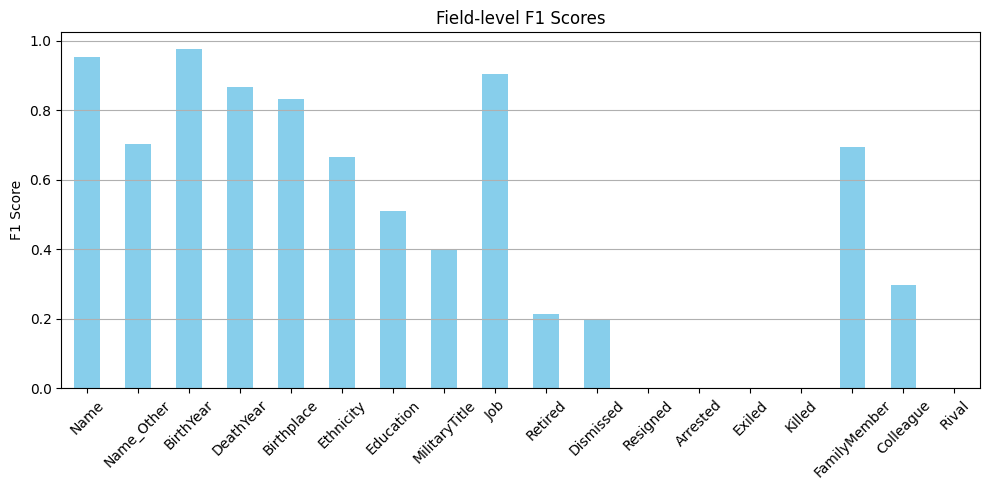

In [ ]:
# === Plot F1 Scores (finetune + 1 shot) ===
eval_field_df["F1"].plot(kind="bar", figsize=(10, 5), title="Field-level F1 Scores", color="skyblue")
plt.ylabel("F1 Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

In [ ]:
eval_sim_df

,Value
JSON_Valid (%),93.480
Exact_Match (%),2.170
Avg_Jaccard_Similarity (all),0.699
Avg_Cosine_Similarity (all),0.864
Avg_Jaccard_Similarity (valid_only),0.748
Avg_Cosine_Similarity (valid_only),0.924
Macro_Precision,0.469
Macro_Recall,0.459
Macro_F1,0.457
Unknown_Keys_Total,0.000


In [ ]:
eval_field_df

,Precision,Recall,F1,Hallucinated,Missed
Name,0.953,0.953,0.953,2,2
Name_Other,0.650,0.765,0.703,7,4
BirthYear,0.953,1.000,0.976,2,0
DeathYear,0.852,0.885,0.868,4,3
Birthplace,0.814,0.854,0.833,8,6
Ethnicity,1.000,0.500,0.667,0,2
Education,0.467,0.560,0.509,16,11
MilitaryTitle,0.375,0.429,0.400,10,8
Job,0.884,0.927,0.905,5,3
Retired,0.250,0.188,0.214,9,13


#### Llama 3.3 70B (1 shot + constraint)
Distilabel & TogetherAI (with Instructor as constraint for structured JSON output)

In [ ]:
from datasets import load_dataset
dataset_test = load_dataset("json", data_files="/content/llm_train_2025.12.10_alpaca_testset.jsonl",
    split="train",   # <- key name in the DatasetDict
)

# Verify the split
print(dataset_test)

Dataset({
    features: ['input', 'output', 'text'],
    num_rows: 46
})


In [ ]:
!pip install distilabel[instructor]

In [ ]:
### Pydantic Model for Flattened Schema (Updated 2025.12.10)
from pydantic import BaseModel
from typing import List, Optional

class Birthloc(BaseModel):
    City: str = ""
    City_OtherName: List[str] = []
    Region: str = ""
    Region_OtherName: List[str] = []

class Edu(BaseModel):
    School: str = ""
    OtherName: List[str] = []
    Start: str = ""
    End: str = ""
    Level: str = ""
    Field: str = ""
    Location: List[str] = []

class Military_Title(BaseModel):
    Title: str = ""
    YearReceived: str = ""

class JobModel(BaseModel):
    Start: str = ""
    End: str = ""
    Position: str = ""
    Location: List[str] = []
    Org_Main_Name: str = ""
    Org_Main_OtherName: str = ""
    Org_Department: str = ""
    Org_Unit: str = ""

class CareerEvent(BaseModel):
    Date: str = ""
    Detail: List[str] = []

class FamRelation(BaseModel):
    Name: str = ""
    Relation: str = ""

class Coworker(BaseModel):
    FirstMention_Year: str = ""
    Name: List[str] = []

class Opponent(BaseModel):
    FirstMention_Year: str = ""
    Name: List[str] = []


class Biography(BaseModel):
    Name: Optional[str] = None
    Name_Other: Optional[List[str]] = None
    BirthYear: Optional[str] = None
    DeathYear: Optional[str] = None
    Birthplace: Optional[Birthloc] = None
    Ethnicity: Optional[List[str]] = None
    Education: Optional[List[Edu]] = None
    MilitaryTitle: Optional[List[Military_Title]] = None
    Job: Optional[List[JobModel]] = None
    Retired: Optional[List[CareerEvent]] = None
    Dismissed: Optional[List[CareerEvent]] = None
    Resigned: Optional[List[CareerEvent]] = None
    Arrested: Optional[List[CareerEvent]] = None
    Exiled: Optional[List[CareerEvent]] = None
    Killed: Optional[List[CareerEvent]] = None
    FamilyMember: Optional[List[FamRelation]] = None
    Colleague: Optional[List[Coworker]] = None
    Rival: Optional[List[Opponent]] = None

In [ ]:
# Load the Llama model (with constraint)
from distilabel.models.llms import TogetherLLM

llama_70B = TogetherLLM(model="meta-llama/Llama-3.3-70B-Instruct-Turbo",
                         api_key="your-API-key",
                         structured_output={"format": "json", "schema": Biography})

# Check if initialization is successful
if llama_70B is None:
    print("❌ ERROR: Model initialization failed!")
else:
    print("✅ Model initialized successfully.")

# Check if the model loads successfully
try:
    llama_70B.load()
    print("✅ Model loaded successfully.")
except Exception as e:
    print(f"❌ ERROR: Model failed to load! \n{e}")

✅ Model initialized successfully.
✅ Model loaded successfully.


In [ ]:
dataset_test[0]['input']

"Viktor Fedorovich Yerin, a prominent Russian statesman, was born on January 17, 1944, in Kazan, Tatarstan region, and passed away on March 19, 2018, in Moscow. His distinguished career spanned several decades, during which he held various high-ranking positions in the Russian government. He is also known as Viktor Fyodorovich Erin, Viktor Erin, V. F. Erin, Viktor Yerin, or V. F. Yerin.\n\nYerin's professional journey began in 1960 when he worked as a toolmaker at the Kazan Aviation Plant named after Gorbunov. He pursued his education at the Kazan branch of the Yelabuga Secondary Police School, graduating with honors in 1967. He furthered his studies at the Higher School of the USSR Ministry of Internal Affairs, also graduating with honors in 1973.\n\nYerin's service in the internal affairs bodies commenced in 1964 as a district police officer of the Leninsky ROOOP in Kazan. He subsequently held various positions in the internal affairs bodies of Tatarstan, including operational commis

In [ ]:
# Helper: Fixed JSON structure (template) for formatting prompt
json_schema = """
{"Name": "", "Name_Other": [], "BirthYear": "", "DeathYear": "", "Birthplace": {"City": "", "City_OtherName": [], "Region": "", "Region_OtherName": []}, "Ethnicity": [], "Education": [{"School": "", "OtherName": [], "Start": "", "End": "", "Level": "", "Field": "", "Location": []}], "MilitaryTitle": [{"Title": "", "YearReceived": ""}], "Job": [{"Start": "", "End": "", "Position": "", "Location": [], "Org_Main_Name": "", "Org_Main_OtherName": "", "Org_Department": "", "Org_Unit": ""}], "Retired": [{"Date": "", "Detail": []}], "Dismissed": [{"Date": "", "Detail": []}], "Resigned": [{"Date": "", "Detail": []}], "Arrested": [{"Date": "", "Detail": []}], "Exiled": [{"Date": "", "Detail": []}], "Killed": [{"Date": "", "Detail": []}], "FamilyMember": [{"Name": "", "Relation": ""}], "Colleague": [{"FirstMention_Year": "", "Name": []}], "Rival": [{"FirstMention_Year": "", "Name": []}]}
"""

json_example = """
{
  "Name": "To Huy Rua",
  "Name_Other": [],
  "BirthYear": "1947",
  "Birthplace": {"City": "Quang Xuong", "City_OtherName": [], "Region": "Thanh Hoa",  "Region_OtherName": []},
  "Education": [
    {"School": "Central Propaganda School", "OtherName": ["Academy of Journalism and Communication"], "Start": "1970", "End": "1974", "Level": "", "Field": "", "Location": []},
    {"School": "Hanoi University of Science", "OtherName": ["Vietnam National University, Hanoi"], "Start": "1975", "End": "1979", "Level": "University", "Field": "Mathematics", "Location": ["Hanoi"]},
    {"School": "Academy of Social Sciences", "OtherName": [], "Start": "1980", "End": "1986", "Level": "Doctorate", "Field": "Philosophy", "Location": ["USSR"]}
      ],
  "Job": [
    {"Start": "1965", "End": "1970", "Position": "Military Service", "Location": ["South"], "Org_Main_Name": "", "Org_MainOtherName": "", "Org_Department": "", "Org_Unit": ""},
    {"Start": "1974", "End": "1979", "Position": "Teaching Assistant", "Location": [], "Org_Main_Name": "Central Propaganda School", "Org_Main_OtherName": "Academy of Journalism and Communication", "Org_Department": "", "Org_Unit": ""},
    {"Start": "1986", "End": "", "Position": "Deputy Head", "Location": [], "Org_Main_Name": "Hanoi University of Science", "Org_Main_OtherName": "", "Org_Department": "", "Org_Unit": ""},
    {"Start": "2000", "End": "", "Position": "Secretary", "Location": ["Hai Phong"], "Org_Main_Name": "City Party Committee", "Org_Main_OtherName": "", "Org_Department": "", "Org_Unit": ""}
    ],
  "Retired": [{"Date": "January 2016", "Detail": ["At the 12th National Congress (January 2016) he retired."]}],
  "FamilyMember": [{"Name": "Truong Tuyet Nhung", "Relation": "Wife"}, {"Name": "To Tu Ha", "Relation": "Son"}, {"Name": "To Huy Vu", "Relation": "Son"}],
  "Colleague": [{"FirstMention_Year": "1999", "Name": ["Le Kha Phieu"]}, {"FirstMention_Year": "", "Name": ["Pham Van Vung"]}]
}
"""

# Template for each input
def build_prompt(biography_text):
    return f"""
You are an expert historian and political scientist specializing in biographies of political elites. Below is an example of how to extract information from a biography and store them in JSON structure.
### Here is an Example Biography and Example JSON Output:
**Example Biography:**
To Huy Rua (born 1947) is a Vietnamese politician. He was a former Head of the Central Organization Committee , Director of the Ho Chi Minh National Academy of Politics , and Director of the Central Propaganda School. He has a university degree in Mathematics and a Doctorate in Philosophy. [ 1 ]
Biography
He was born on June 4, 1947, in Quang Thai commune, Quang Xuong district , Thanh Hoa province .
In 1965, he volunteered to serve in the battlefield in the Southern region until 1970, when he attended the Central Propaganda School (now the Academy of Journalism and Communication), majoring in Philosophy. After graduating in 1974, he was retained as a teaching assistant at the school's Faculty of Philosophy. During his time as a teaching assistant, he registered for additional studies (1975 – 1979) and earned a Bachelor's degree in Mathematics at Hanoi University of Science (now Vietnam National University, Hanoi).
In 1980, To Huy Rua was a postgraduate student in Philosophy at the Academy of Social Sciences of the USSR. After successfully defending doctoral thesis in 1986, he returned to Vietnam and became Deputy Head of the Faculty of Philosophy, Hanoi University of Science (now Vietnam National University, Hanoi).
From 1990 to 1995, he was selected Director of the Central Propaganda School. During this time, he was awarded the title of Associate Professor.
At the end of 1999, he was appointed by his fellow countryman (similar native province), General Secretary (of the CPV) Le Kha Phieu, as Secretary of the Hai Phong City Party Committee, a position he began in 2000.
At the 12th National Congress (January 2016) he retired.
Family
• His wife is Ms. Truong Tuyet Nhung, former Head of Training Department, Academy of Journalism and Propaganda.
• First son: To Tu Ha, Director of Noi Bai International Airport.
• Second son: To Huy Vu, currently Director of the International Cooperation Department of the State Bank of Vietnam.
Controversial political activity
To Huy Rua was reported to having sponsored the rise of Pham Van Vung to be a Navy Political Commissar. When he became Navy Political Commissar, Pham Van Vung was forced to hand over his position after 1 year in office due to his corrupt behavior.

**Expected JSON Output:**
{json_example}

### Task:
Your task is to generate a structured JSON record that captures key details of an elite's life, education, and career based on his/her biography below.

**Biography:**
{biography_text}

The JSON output must follow the **structure and key names** below.

{json_schema}

Formatting Rules:
- Only generate 1 JSON output for each biography.
- Use only the information in the biography.
- **Do not fabricate or rename any JSON keys.** Use only the fields and labels shown in the template.
- **Preserve the exact structure of the JSON object**, including all nested levels.
- If a **nested subfield** (e.g., "OtherName" under "Education") is missing, **include the key but leave it empty**.
- If a **top-level JSON field** (e.g., "DeathYear", "Exiled", "Rival") has absolutely no information, **omit the entire top-level field**.
"""


In [ ]:
test_output = llama_model.generate_outputs(
    inputs=[[{"role": "user", "content": biography_text}]],  # ✅ Use Distilabel format
    max_new_tokens=2200,
    temperature=0.15)

In [ ]:
test_output[0]['generations']

['{"Name":"Viktor Fedorovich Yerin","Name_Other":["Viktor Fyodorovich Erin","Viktor Erin","V. F. Erin","Viktor Yerin","V. F. Yerin"],"BirthYear":"1944","DeathYear":"2018","Birthplace":{"City":"Kazan","City_OtherName":null,"Region":"Tatarstan","Region_OtherName":null},"Ethnicity":null,"Education":[{"School":"Kazan branch of the Yelabuga Secondary Police School","OtherName":null,"Start":"1960","End":"1967","Level":"Secondary","Field":"Police","Location":["Kazan"]},{"School":"Higher School of the USSR Ministry of Internal Affairs","OtherName":null,"Start":"1967","End":"1973","Level":"Higher","Field":"Internal Affairs","Location":["Moscow"]}],"MilitaryTitle":null,"Job":[{"Start":"1960","End":"1964","Position":"Toolmaker","Organization":{"MainOrg":"Kazan Aviation Plant","MainOrg_OtherName":null,"SubOrg":null,"Unit":null},"Location":["Kazan"]},{"Start":"1964","End":"1980","Position":"District police officer","Organization":{"MainOrg":"Leninsky ROOOP","MainOrg_OtherName":null,"SubOrg":null,"U

In [ ]:
from datasets import load_dataset
from distilabel.models import TogetherLLM
from tqdm import tqdm

# ===== Run inference over the test dataset =====
import json

predictions = []
for example in tqdm(dataset_test):
    full_prompt = build_prompt(example["input"])

    try:
        output = llama_70B.generate_outputs(
            inputs=[[{"role": "user", "content": full_prompt}]],
            max_new_tokens=2300,
            temperature=0.15
        )
        raw_json = output[0]['generations'][0]

    except Exception as e:
        print(f"⚠️ Error at example {example['input'][:50]}...: {e}")
        raw_json = ""

    predictions.append({
        "input": example["input"],
        "expected_output": example["output"],
        "prediction": raw_json
    })



100%|██████████| 46/46 [06:32<00:00,  8.53s/it]


In [ ]:
# ===== Post-Processing to Remove Top-Level Fields that are Null =====
def clean_top_level_nulls(d: dict) -> dict:
    def is_effectively_empty(value):
        if isinstance(value, dict):
            return all(is_effectively_empty(v) for v in value.values())
        elif isinstance(value, list):
            return all(is_effectively_empty(v) for v in value)
        return value in (None, "", [])

    return {
        k: v for k, v in d.items()
        if not is_effectively_empty(v)
    }

import json

for pred in predictions:
    try:
        parsed = json.loads(pred['prediction'])
        cleaned = clean_top_level_nulls(parsed)
        cleaned_str = json.dumps(cleaned, ensure_ascii=False)  # dict -> pretty string
        pred["prediction_cleaned"] = cleaned_str  # add a new field with cleaned output
    except json.JSONDecodeError:
        pred["prediction_cleaned"] = {}  # fallback if JSON is invalid

In [ ]:
predictions[0]

{'input': "Viktor Fedorovich Yerin, a prominent Russian statesman, was born on January 17, 1944, in Kazan, Tatarstan region, and passed away on March 19, 2018, in Moscow. His distinguished career spanned several decades, during which he held various high-ranking positions in the Russian government. He is also known as Viktor Fyodorovich Erin, Viktor Erin, V. F. Erin, Viktor Yerin, or V. F. Yerin.\n\nYerin's professional journey began in 1960 when he worked as a toolmaker at the Kazan Aviation Plant named after Gorbunov. He pursued his education at the Kazan branch of the Yelabuga Secondary Police School, graduating with honors in 1967. He furthered his studies at the Higher School of the USSR Ministry of Internal Affairs, also graduating with honors in 1973.\n\nYerin's service in the internal affairs bodies commenced in 1964 as a district police officer of the Leninsky ROOOP in Kazan. He subsequently held various positions in the internal affairs bodies of Tatarstan, including operatio

In [ ]:
import json
output_path = "/content/drive/MyDrive/EliteNet_FineTunning/Finetune4_2025.12.10/test_pred_2025.12.10_llama70B1shotcon.json"
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(predictions, f, ensure_ascii=False, indent=2)

print(f"✅ Saved predictions to {output_path}")

✅ Saved predictions to /content/drive/MyDrive/EliteNet_FineTunning/Finetune4_2025.12.10/test_pred_2025.12.10_llama70B1shotcon.json


In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# ================== CONFIG ==================

# --- Paths (adjust as needed) ---
predictions_path = "/content/drive/MyDrive/EliteNet_FineTunning/Finetune4_2025.12.10/test_pred_2025.12.10_llama70B1shotcon.json"
eval_sim_csv_path = "/content/drive/MyDrive/EliteNet_FineTunning/Finetune4_2025.12.10/eval_sim_70B1shotcon.csv"
eval_field_csv_path = "/content/drive/MyDrive/EliteNet_FineTunning/Finetune4_2025.12.10/eval_field_70B1shotcon.csv"
per_example_csv_path = "/content/drive/MyDrive/EliteNet_FineTunning/Finetune4_2025.12.10/per_example_eval_70B1shotcon.csv"

# --- Fields to evaluate (top-level schema) ---
fields_to_check = [
    "Name", "Name_Other", "BirthYear", "DeathYear", "Birthplace", "Ethnicity",
    "Education", "MilitaryTitle", "Job", "Retired", "Dismissed", "Resigned",
    "Arrested", # "Exiled", "Killed",
    "FamilyMember", "Colleague", "Rival",
]

ALLOWED_TOP_LEVEL = set(fields_to_check)

# --- Nested list-of-dicts fields where we want Jaccard + key-based matching ---
NESTED_LIST_FIELDS = {
    "Education", "Job", "Retired",
    "Dismissed", "Resigned", "Arrested", # "Exiled", "Killed",
    "Colleague", "Rival",
}

# For each nested field, define which keys inside each dict are "core" for matching.
# You should adjust these to your actual schema. For keys not listed here, all keys will be used.
CORE_KEYS_PER_FIELD = {
    "MilitaryTitle": ["Title", "YearReceived"],
    "Education":    ["School", "Start", "End", "Location"],
    "Job":          ["Start", "End", "Position", "Location", "Org_Main_Name", "Org_Department", "Org_Unit"],
    "Retired":      ["Date", "Reason"],
    "Dismissed":    ["Date", "Reason"],
    "Resigned":     ["Date", "Reason"],
    "Arrested":     ["Date", "Reason"],
    # "Exiled":       ["Date", "Reason", "Country"],
    # "Killed":       ["Date", "Cause", "Location"],
    "Colleague":    [#"FirstMention_Year",
                     "Name"],
    "Rival":        [#"FirstMention_Year",
                     "Name"],
}

# Jaccard threshold for considering a nested field as a "match" (TP)
NESTED_MATCH_THRESHOLD = 0.6

# ================== HELPERS ==================

def try_parse_json(s):
    try:
        return json.loads(s), True
    except Exception:
        return None, False

def flatten_json_fields_with_presence(json_obj):
    """
    Returns:
        flat:    dict[field_name -> string representation]
        present: dict[field_name -> bool] (whether the field key exists at top level)
    """
    flat = {}
    present = {}
    for field in fields_to_check:
        if field in json_obj:
            present[field] = True
            val = json_obj[field]
        else:
            present[field] = False
            val = None

        if isinstance(val, (list, dict)):
            flat[field] = json.dumps(val, sort_keys=True, ensure_ascii=False)
        elif val is None:
            flat[field] = ""
        else:
            flat[field] = str(val)
    return flat, present

def compute_cosine_sim(a, b):
    vec = TfidfVectorizer().fit_transform([a, b])
    return cosine_similarity(vec[0:1], vec[1:2])[0][0]

def compute_jaccard_sim(a, b):
    set1, set2 = set(a.split()), set(b.split())
    return len(set1 & set2) / len(set1 | set2) if (set1 | set2) else 1.0

def unknown_keys(json_obj):
    return [k for k in json_obj.keys() if k not in ALLOWED_TOP_LEVEL]

def _to_list(val):
    """Helper: normalize a field value to a list (or empty list)."""
    if val is None:
        return []
    if isinstance(val, str):
        try:
            parsed = json.loads(val)
            if isinstance(parsed, list):
                return parsed
            else:
                return []
        except Exception:
            return []
    if isinstance(val, list):
        return val
    return []

def _canon_dict(d, core_keys=None):
    """
    Canonicalize a dict to a JSON string using only core_keys (if provided).
    If core_keys is None, use the dict as-is.
    """
    if not isinstance(d, dict):
        return None
    if core_keys:
        core = {k: d.get(k) for k in core_keys if k in d}
    else:
        core = d
    return json.dumps(core, sort_keys=True, ensure_ascii=False)

def list_of_dicts_jaccard(pred_val, gold_val, field_name=None):
    """
    Compute Jaccard similarity between two list-of-dicts fields using only
    "core" keys specified for that field (if provided).
    """
    try:
        pred_list = _to_list(pred_val)
        gold_list = _to_list(gold_val)
        core_keys = CORE_KEYS_PER_FIELD.get(field_name, None)

        set_p = set()
        for item in pred_list:
            c = _canon_dict(item, core_keys=core_keys)
            if c is not None:
                set_p.add(c)

        set_g = set()
        for item in gold_list:
            c = _canon_dict(item, core_keys=core_keys)
            if c is not None:
                set_g.add(c)

        if not set_p and not set_g:
            return 1.0  # both empty → perfect Jaccard
        if not (set_p or set_g):
            return 0.0

        inter = len(set_p & set_g)
        union = len(set_p | set_g)
        return inter / union if union else 0.0
    except Exception:
        return 0.0

# ================== LOAD PREDICTIONS ==================

with open(predictions_path, "r", encoding="utf-8") as f:
    test_pred = json.load(f)

total = len(test_pred)

# ================== METRICS STRUCTURES ==================

fieldwise_scores = {
    f: {"tp": 0, "fp": 0, "fn": 0, "hallucinated": 0, "missed": 0}
    for f in fields_to_check
}

# For nested fields, track per-example Jaccard to report averages
nested_field_jaccards = {f: [] for f in NESTED_LIST_FIELDS}

json_valid_count = 0
exact_match_count = 0

cosine_sims_all = []
jaccard_sims_all = []
cosine_sims_valid = []
jaccard_sims_valid = []

unknown_key_total = 0

per_example_rows = []

# ================== MAIN EVAL LOOP ==================

for entry in test_pred:
    gold_json, gold_valid = try_parse_json(entry["expected_output"])
    pred_json, pred_valid = try_parse_json(entry["prediction"])

    json_valid_count += int(pred_valid)

    cos_sim = 0.0
    jac_sim = 0.0

    if (
        pred_valid and gold_valid
        and isinstance(gold_json, dict)
        and isinstance(pred_json, dict)
    ):
        # Exact JSON match
        exact_match = (pred_json == gold_json)
        exact_match_count += int(exact_match)

        flat_gold, gold_present = flatten_json_fields_with_presence(gold_json)
        flat_pred, pred_present = flatten_json_fields_with_presence(pred_json)

        # Similarities on concatenated text of all fields
        all_gold_text = " ".join(flat_gold.values())
        all_pred_text = " ".join(flat_pred.values())
        cos_sim = compute_cosine_sim(all_pred_text, all_gold_text)
        jac_sim = compute_jaccard_sim(all_pred_text, all_gold_text)

        cosine_sims_valid.append(cos_sim)
        jaccard_sims_valid.append(jac_sim)

        # Unknown keys
        unknowns = unknown_keys(pred_json)
        unknown_key_total += len(unknowns)

        # Per-field metrics
        for f in fields_to_check:
            g_has = gold_present[f]
            p_has = pred_present[f]

            # CASE 1: field absent as a key in both → ignore (no free TP)
            if not g_has and not p_has:
                continue

            # Nested list-of-dicts fields: use Jaccard + key-based matching
            if f in NESTED_LIST_FIELDS:
                g_raw = gold_json.get(f, None)
                p_raw = pred_json.get(f, None)

                g_list = _to_list(g_raw)
                p_list = _to_list(p_raw)

                g_empty = len(g_list) == 0
                p_empty = len(p_list) == 0

                # Track Jaccard for analysis (even if empty)
                j_nested = list_of_dicts_jaccard(p_raw, g_raw, field_name=f)
                nested_field_jaccards[f].append(j_nested)

                # CASE N1: both lists empty → ignore this example for this field
                if g_empty and p_empty:
                    continue

                # CASE N2: gold has content, pred has none
                if (not g_empty) and p_empty:
                    fieldwise_scores[f]["fn"] += 1
                    fieldwise_scores[f]["missed"] += 1
                    continue

                # CASE N3: pred has content, gold has none
                if g_empty and (not p_empty):
                    fieldwise_scores[f]["fp"] += 1
                    fieldwise_scores[f]["hallucinated"] += 1
                    continue

                # CASE N4: both have non-empty lists → use Jaccard threshold
                if j_nested >= NESTED_MATCH_THRESHOLD:
                    fieldwise_scores[f]["tp"] += 1
                else:
                    fieldwise_scores[f]["fp"] += 1
                    fieldwise_scores[f]["fn"] += 1
                    fieldwise_scores[f]["hallucinated"] += 1
                    fieldwise_scores[f]["missed"] += 1

            else:
                # Non-nested fields: use stricter equality + presence

                g_val = flat_gold[f]   # string
                p_val = flat_pred[f]   # string

                # CASE S1: both keys present
                if g_has and p_has:
                    if g_val == p_val:
                        fieldwise_scores[f]["tp"] += 1
                    else:
                        fieldwise_scores[f]["fp"] += 1
                        fieldwise_scores[f]["fn"] += 1
                        fieldwise_scores[f]["hallucinated"] += 1
                        fieldwise_scores[f]["missed"] += 1

                # CASE S2: gold has field, pred omits it
                elif g_has and not p_has:
                    fieldwise_scores[f]["fn"] += 1
                    fieldwise_scores[f]["missed"] += 1

                # CASE S3: pred has field, gold omits it
                elif p_has and not g_has:
                    fieldwise_scores[f]["fp"] += 1
                    fieldwise_scores[f]["hallucinated"] += 1

    # If invalid JSON on either side:
    cosine_sims_all.append(cos_sim)
    jaccard_sims_all.append(jac_sim)

    per_example_rows.append({
        "input": entry["input"],
        "expected_output": entry["expected_output"],
        "prediction": entry["prediction"],
        "gold_json_valid": gold_valid,
        "pred_json_valid": pred_valid,
        "cosine_all": cos_sim,
        "jaccard_all": jac_sim,
    })

# ================== AGGREGATE METRICS ==================

field_metrics = {}
for f in fields_to_check:
    scores = fieldwise_scores[f]
    tp, fp, fn = scores["tp"], scores["fp"], scores["fn"]
    precision = tp / (tp + fp) if (tp + fp) else 0.0
    recall = tp / (tp + fn) if (tp + fn) else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0.0
    field_metrics[f] = {
        "Precision": round(precision, 3),
        "Recall": round(recall, 3),
        "F1": round(f1, 3),
        "Hallucinated": scores["hallucinated"],
        "Missed": scores["missed"],
    }

# Macro averages
macro_precision = sum(m["Precision"] for m in field_metrics.values()) / len(field_metrics)
macro_recall    = sum(m["Recall"] for m in field_metrics.values()) / len(field_metrics)
macro_f1        = sum(m["F1"] for m in field_metrics.values()) / len(field_metrics)

# Overall similarities
evaluation_sim = {
    "JSON_Valid (%)": round(json_valid_count / total * 100, 2),
    "Exact_Match (%)": round(exact_match_count / total * 100, 2),
    "Avg_Jaccard_Similarity (all)": round(sum(jaccard_sims_all) / total, 3),
    "Avg_Cosine_Similarity (all)": round(sum(cosine_sims_all) / total, 3),
    "Avg_Jaccard_Similarity (valid_only)": round(
        sum(jaccard_sims_valid) / len(jaccard_sims_valid), 3
    ) if jaccard_sims_valid else 0.0,
    "Avg_Cosine_Similarity (valid_only)": round(
        sum(cosine_sims_valid) / len(cosine_sims_valid), 3
    ) if cosine_sims_valid else 0.0,
    "Macro_Precision": round(macro_precision, 3),
    "Macro_Recall": round(macro_recall, 3),
    "Macro_F1": round(macro_f1, 3),
    "Unknown_Keys_Total": unknown_key_total,
    "Unknown_Keys_per_Doc": round(unknown_key_total / total, 3),
}

# Add per-field average Jaccard for nested fields
for f in NESTED_LIST_FIELDS:
    vals = nested_field_jaccards.get(f, [])
    key_name = f"Avg_{f}_Jaccard"
    evaluation_sim[key_name] = round(sum(vals) / len(vals), 3) if vals else 0.0

# ================== SAVE TO CSV ==================

eval_sim_df = pd.DataFrame.from_dict(evaluation_sim, orient="index", columns=["Value"])
eval_field_df = pd.DataFrame.from_dict(field_metrics, orient="index")
per_example_df = pd.DataFrame(per_example_rows)

eval_sim_df.to_csv(eval_sim_csv_path)
eval_field_df.to_csv(eval_field_csv_path)
per_example_df.to_csv(per_example_csv_path, index=False)

print("Saved:")
print("  -", eval_sim_csv_path)
print("  -", eval_field_csv_path)
print("  -", per_example_csv_path)


Saved:
  - /content/drive/MyDrive/EliteNet_FineTunning/Finetune4_2025.12.10/eval_sim_70B1shotcon.csv
  - /content/drive/MyDrive/EliteNet_FineTunning/Finetune4_2025.12.10/eval_field_70B1shotcon.csv
  - /content/drive/MyDrive/EliteNet_FineTunning/Finetune4_2025.12.10/per_example_eval_70B1shotcon.csv


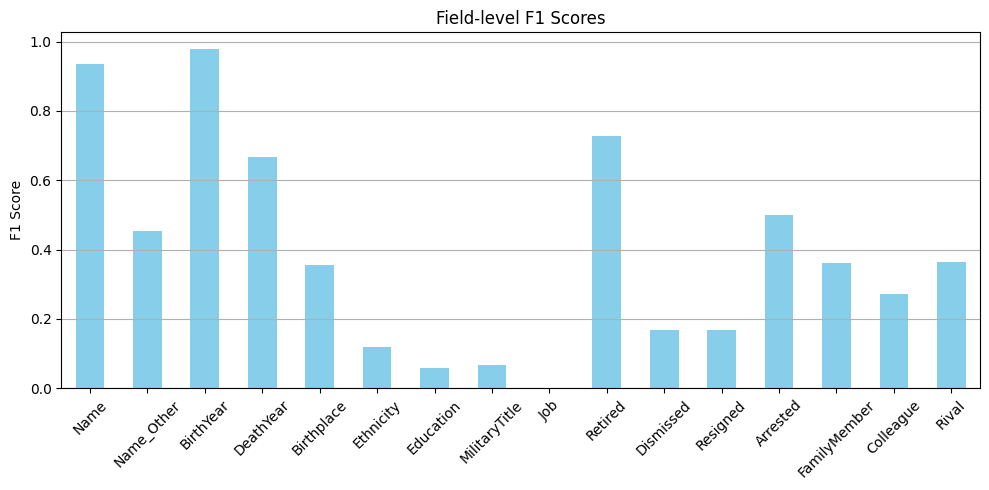

In [ ]:
# === Plot F1 Scores (finetune + 1 shot) ===
eval_field_df["F1"].plot(kind="bar", figsize=(10, 5), title="Field-level F1 Scores", color="skyblue")
plt.ylabel("F1 Score")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

In [ ]:
eval_sim_df

,Value
JSON_Valid (%),100.000
Exact_Match (%),0.000
Avg_Jaccard_Similarity (all),0.521
Avg_Cosine_Similarity (all),0.836
Avg_Jaccard_Similarity (valid_only),0.521
Avg_Cosine_Similarity (valid_only),0.836
Macro_Precision,0.228
Macro_Recall,0.344
Macro_F1,0.259
Unknown_Keys_Total,0.000


In [ ]:
eval_field_df

,Precision,Recall,F1,Hallucinated,Missed
Name,0.935,0.935,0.935,3,3
Name_Other,0.326,0.750,0.455,31,5
BirthYear,0.957,1.000,0.978,2,0
DeathYear,0.543,0.862,0.667,21,4
Birthplace,0.348,0.364,0.356,30,28
Ethnicity,0.065,0.600,0.118,43,2
Education,0.152,0.250,0.189,39,21
MilitaryTitle,0.043,0.143,0.067,44,12
Job,0.326,0.341,0.333,31,29
Retired,0.065,0.188,0.097,43,13


<a name="Save"></a>
### Saving, loading finetuned models
There're 2 ways to save a fine-tuned model:
* (1) Saving only LoRA adapters:
  * Pros:
    * Fast saving & Minimal storage
    * Flexibility: Good for version control & quickly saving versions of models after each fine-tuning round (before evaluation)
  * Cons:
    * Less convenient deployment: Loading base model (in addition to LoRA adapters) is required before inference
    * Potential inference latency: (since both the base model & LoRA adapters are being used at the same time)
* (2) the fully merged model:
  * Pros:
    * Convenient deployment: Only 1 fully merged model needs to be loaded
    * Optimized inference: No inference latency, since there's 1 single model
  * Cons:
    * Heavier --> slow saving & higher storage
    * Lower flexibility: More costly & time-consuming to save and load each full model

Given the strengths & drawbacks of each method, I use method (1) (LoRA adapters) to save the fine-tuned model after each fine-tuning experiementation. I then reload them for evaluation (on test data) later.

Only after I find the fine-tuned LLM to have good eveluation results (on test data) will I save the fully merged model with method (2).

##### Push the Model to HF (LoRA Adapters & PEFT config only)





In [ ]:
# Logging in Hugging Face
from huggingface_hub import login

# Log in using your Hugging Face token (get it from https://huggingface.co/settings/tokens)
login("yourHFtoken") # The token is fine-grained type

In [ ]:
from huggingface_hub import create_repo
repo_id = "tu-ericngo/NuExtract-StructuredIE-v2.7.2"
create_repo(repo_id, exist_ok=True)

# Save LoRA adapter weights + PEFT config
trainer.model.save_pretrained(repo_id)  # or OUTPUT_DIR

# Save processor/tokenizer too (important for NuExtract)
processor.save_pretrained(repo_id)

# Push to hub
trainer.model.push_to_hub(repo_id)
processor.push_to_hub(repo_id)


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...adapter_model.safetensors:   0%|          | 54.9kB /  190MB            

README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...mpt0b3n0fi/tokenizer.json: 100%|##########| 11.4MB / 11.4MB            

CommitInfo(commit_url='https://huggingface.co/tu-ericngo/NuExtract-StructuredIE-v2.7.2/commit/81cc4455b3f9d15f67baebcd1106254b700808a9', commit_message='Upload processor', commit_description='', oid='81cc4455b3f9d15f67baebcd1106254b700808a9', pr_url=None, repo_url=RepoUrl('https://huggingface.co/tu-ericngo/NuExtract-StructuredIE-v2.7.2', endpoint='https://huggingface.co', repo_type='model', repo_id='tu-ericngo/NuExtract-StructuredIE-v2.7.2'), pr_revision=None, pr_num=None)

##### Merge Models & Push to HF (Heavier and Consumes More RAM & Compute Credits)

In [ ]:
from huggingface_hub import create_repo

repo_id = "tu-ericngo/NuExtract-StructuredIE-v1.2.2"
create_repo(repo_id, exist_ok=True)

# Merge LoRA
merged_model = trainer.model.merge_and_unload()

# Push model
merged_model.push_to_hub(repo_id, safe_serialization=True)

# Push processor / tokenizer
processor.push_to_hub(repo_id)

# Push generation config explicitly (recommended)
if hasattr(merged_model, "generation_config") and merged_model.generation_config is not None:
    merged_model.generation_config.push_to_hub(repo_id)


Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...0002-of-00004.safetensors:   0%|          |  611kB / 4.99GB            

  ...0003-of-00004.safetensors:   0%|          |  611kB / 4.93GB            

  ...0004-of-00004.safetensors:   3%|2         | 50.3MB / 1.69GB            

  ...0001-of-00004.safetensors:   0%|          | 15.9kB / 4.97GB            

README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...mpuixiez5r/tokenizer.json: 100%|##########| 11.4MB / 11.4MB            

No files have been modified since last commit. Skipping to prevent empty commit.


In [ ]:
### How to Load It Later ###
from transformers import AutoProcessor, AutoModelForVision2Seq

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

processor = AutoProcessor.from_pretrained(
    "tu-ericngo/NuExtract-StructuredIE-v1.2.2",
    trust_remote_code=True,
    padding_side="left",
    use_fast=True,
    )

model = AutoModelForVision2Seq.from_pretrained(
    "tu-ericngo/NuExtract-StructuredIE-v1.2.2",
    trust_remote_code=True,
    torch_dtype=torch.bfloat16 if DEVICE == "cuda" else torch.float32,
    device_map="auto" if DEVICE == "cuda" else None,
    )